In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from joblib import load

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed
set_random_seed(12)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaco

# Preprocessing

In [2]:
data = pd.read_csv('./datasets/IBM_daily.csv').sort_values(by='date')

In [3]:
data

,date,1. open,2. high,3. low,4. close,5. volume
5217,1999-11-01,98.50,98.8100,96.37,96.75,9551800.0
5216,1999-11-02,96.75,96.8100,93.69,94.81,11105400.0
5215,1999-11-03,95.87,95.9400,93.50,94.37,10369100.0
5214,1999-11-04,94.44,94.4400,90.00,91.56,16697600.0
5213,1999-11-05,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...,...
4,2020-07-22,125.90,129.4700,125.80,128.67,8195366.0
3,2020-07-23,129.10,129.3700,127.15,127.33,4220136.0
2,2020-07-24,126.48,127.6459,125.50,125.79,3531076.0
1,2020-07-27,124.86,126.3200,124.71,126.21,3733547.0


In [4]:
data = data.drop(columns='date')
data

,1. open,2. high,3. low,4. close,5. volume
5217,98.50,98.8100,96.37,96.75,9551800.0
5216,96.75,96.8100,93.69,94.81,11105400.0
5215,95.87,95.9400,93.50,94.37,10369100.0
5214,94.44,94.4400,90.00,91.56,16697600.0
5213,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...
4,125.90,129.4700,125.80,128.67,8195366.0
3,129.10,129.3700,127.15,127.33,4220136.0
2,126.48,127.6459,125.50,125.79,3531076.0
1,124.86,126.3200,124.71,126.21,3733547.0


In [5]:
# Sequence for the LSTM network
backlook = 92

# Days to predict
days = 3

# Size of data split for testing
train_size = 0.9

In [6]:
# Train-Test split
split = int(len(data) * train_size)

train = data.to_numpy()[:split]
test = data.to_numpy()[split:]

In [7]:
# Load normalisers
normaliser = load('./normalisers/x_normaliser.joblib')
y_normaliser = load('./normalisers/y_normaliser.joblib')

In [8]:
# Normalise data
train_norm = normaliser.transform(train)
test_norm = normaliser.transform(test)

##### Now I get indexes for chunks from 3 in 3 days

In [9]:
index = []

for i in range(days):
    index.append(np.arange(i,len(train),days))

In [10]:
ordered_index = []

for i in range(len(index[0]) - backlook):
    for e in range(days):
        try: ordered_index.append(index[e][i:i+backlook])
        except: pass

In [11]:
# Normalised train chunks
X_train = np.array([train_norm[ix].copy() for ix in ordered_index])
Y_train = np.array([train_norm[ordered_index[i+days][-1],3].copy() for i in range(len(ordered_index) - days)])
Y_train = np.expand_dims(Y_train, -1)

In [12]:
# Delete those sequences that doesn't have a -th day in the results
X_train = X_train[:Y_train.shape[0]]

##### Same for test

In [13]:
index = []

for i in range(days):
    index.append(np.arange(i,len(test),days))

In [14]:
ordered_index = []

for i in range(len(index[0]) - backlook):
    for e in range(days):
        try: ordered_index.append(index[e][i:i+backlook])
        except: pass

In [15]:
# Normalised test chunks
X_test = np.array([test_norm[ix].copy() for ix in ordered_index])
Y_test = np.array([test_norm[ordered_index[i+days][-1],3].copy() for i in range(len(ordered_index) - days)])
Y_test = np.expand_dims(Y_test, -1)

In [16]:
# Delete those sequences that doesn't have a -th day in the results
X_test = X_test[:Y_test.shape[0]]

# Model selection

##### Model constructor

In [17]:
def build_lstm(x, y, batch_size=512, epochs=24, **params):
    
    # List of parameters
    if 'lstmsize' not in params: params['lstmsize'] = x.shape[1]
    if 'density' not in params: params['density'] = int((params['lstmsize']//1.5)*2)
    if 'activation' not in params: params['activation'] = 'relu'
    if 'twice' not in params: params['twice'] = False
    if 'optimizer' not in params: params['optimizer'] = 'adam'
    if 'shuffle' not in params: params['shuffle'] = False
    
    # Model definition
    model = Sequential()
    
    model.add(LSTM(params['lstmsize'], input_shape=x.shape[1:], return_sequences=params['twice']))
    
    if 'dropout' in params:
        model.add(Dropout(params['dropout']))
    
    if params['twice']:
        model.add(LSTM(params['lstmsize']))
        
        if 'dropout' in params:
            model.add(Dropout(params['dropout']))
            
    model.add(Dense(params['density'], activation=params['activation']))
    
    if 'full_density' in params and params['full_density']:
        density = params['density']//2
        while density >= 12:
            model.add(Dense(density, activation=params['activation']))
            density //= 2
            
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse', optimizer=params['optimizer'])
    
    if 'callbacks' in params:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'],
                            callbacks=params['callbacks'])
    else:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'])
    
    return [model, callback, params]

##### Evolutive algorith to search for the most optimal model

In [18]:
def set_genes(x, y, population_size, population=[]):
    if population_size-len(population) < 0:
        print('population size must be greater or equal than actual population')
        return
    
    if len(population) > 0:
        if len(population) < 3:
            print('population should be empty or 3 at least')
            return
        
        population[2] = breed_genes(x, y, population[0][2].copy())
        population[1] = breed_genes(x, y, combine=(population[0][2], population[1][2]))
        population = population[:3]
    
    for _ in range(population_size-len(population)):
        subject = breed_genes(x, y)
        population.append(subject)
        
    return population

def breed_genes(x, y, genes={}, combine=None):
    genes['x'] = x
    genes['y'] = y
    
    if type(combine) is list or type(combine) is tuple:
        genes['lstmsize'] = combine[np.random.randint(0,2)]['lstmsize']
        genes['density'] = combine[np.random.randint(0,2)]['density']
        genes['activation'] = combine[np.random.randint(0,2)]['activation']
        genes['twice'] = combine[np.random.randint(0,2)]['twice']
        genes['optimizer'] = combine[np.random.randint(0,2)]['optimizer']
        genes['shuffle'] = combine[np.random.randint(0,2)]['shuffle']
        
        genes['dropout'] = combine[np.random.randint(0,2)].get('dropout')
        if genes['dropout'] is None: del genes['dropout']
        genes['full_density'] = combine[np.random.randint(0,2)].get('full_density')
        if genes['full_density'] is None: del genes['full_density']
            
    else:
        if np.random.randint(0,3) == 1:
            genes['lstmsize'] = int((np.random.randint(x.shape[1],x.shape[1]*2)//2)*2)

        if np.random.randint(0,3) == 1:
            genes['density'] = int((np.random.randint(x.shape[1]//2,x.shape[1]*2.66)//2)*2)

        if np.random.randint(0,3) == 1:
            activation = [
                'relu',
                'sigmoid',
                'softplus',
                'softsign',
                'tanh',
                'selu',
                'elu',
                'exponential'
            ]
            genes['activation'] = activation[np.random.randint(0,8)]

        if np.random.randint(0,3) == 1:
            genes['twice'] = True

        if np.random.randint(0,3) == 1:
            optimizer = [
                'sgd',
                'rmsprop',
                'adam',
                'adadelta',
                'adagrad',
                'adamax',
                'nadam'
            ]
            genes['optimizer'] = optimizer[np.random.randint(0,7)]

        if np.random.randint(0,3) == 1:
            genes['shuffle'] = True

        if np.random.randint(0,3) == 1:
            genes['dropout'] = np.random.randint(1,4)/10

        if np.random.randint(0,3) == 1:
            genes['full_density'] = True
            
    new_model = build_lstm(**genes)
        
    return new_model

In [19]:
def breed_population(x, y, generations, population_size, population=[]):
    
    if generations > 1 and population_size < 3:
        print('population size should be of a minimum of 3 for more than one generation')
        return
    
    for g in range(generations):
        print(f'\nGENERATION {g}\n')
        population = set_genes(x, y, population_size, population)
        population = sorted(population, key=lambda x: x[1].history['val_loss'][-1]+x[1].history['loss'][-1])
        
    return population

In [20]:
best_models = breed_population(X_train, Y_train, generations=20, population_size=10)


GENERATION 0

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 1s 370us/step - loss: 0.2071 - val_loss: 0.0021
Epoch 2/24
3977/3977 [==============================] - 1s 150us/step - loss: 0.0193 - val_loss: 0.0018
Epoch 3/24
3977/3977 [==============================] - 1s 150us/step - loss: 0.0087 - val_loss: 0.0060
Epoch 4/24
3977/3977 [==============================] - 1s 148us/step - loss: 0.0038 - val_loss: 0.0040
Epoch 5/24
3977/3977 [==============================] - 1s 155us/step - loss: 0.0028 - val_loss: 0.0015
Epoch 6/24
3977/3977 [==============================] - 1s 149us/step - loss: 0.0022 - val_loss: 9.5417e-04
Epoch 7/24
3977/3977 [==============================] - 1s 150us/step - loss: 0.0020 - val_loss: 8.3788e-04
Epoch 8/24
3977/3977 [==============================] - 1s 151us/step - loss: 0.00

3977/3977 [==============================] - 2s 546us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 24/24
3977/3977 [==============================] - 2s 547us/step - loss: 0.0016 - val_loss: 0.0019
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 3s 705us/step - loss: 0.8947 - val_loss: 0.2401
Epoch 2/24
3977/3977 [==============================] - 2s 465us/step - loss: 0.1061 - val_loss: 0.0600
Epoch 3/24
3977/3977 [==============================] - 2s 462us/step - loss: 0.0306 - val_loss: 0.0278
Epoch 4/24
3977/3977 [==============================] - 2s 465us/step - loss: 0.0121 - val_loss: 0.0208
Epoch 5/24
3977/3977 [==============================] - 2s 464us/step - loss: 0.0080 - val_loss: 0.0041
Epoch 6/24
3977/3977 [==============================] - 2s 467us/step - loss: 0.0056 - val_loss: 0.0075
Epoch 7/24
3977/3977 [==============================] - 2s 466us/step - loss: 0.0045 - val_loss: 0.0015
Epoch 8/24
3977/3977 [=====

3977/3977 [==============================] - 2s 539us/step - loss: 0.0226 - val_loss: 0.0097
Epoch 4/24
3977/3977 [==============================] - 2s 531us/step - loss: 0.0116 - val_loss: 0.0036
Epoch 5/24
3977/3977 [==============================] - 2s 538us/step - loss: 0.0069 - val_loss: 0.0031
Epoch 6/24
3977/3977 [==============================] - 2s 533us/step - loss: 0.0056 - val_loss: 0.0028
Epoch 7/24
3977/3977 [==============================] - 2s 534us/step - loss: 0.0044 - val_loss: 0.0011
Epoch 8/24
3977/3977 [==============================] - 2s 532us/step - loss: 0.0041 - val_loss: 0.0016
Epoch 9/24
3977/3977 [==============================] - 2s 535us/step - loss: 0.0036 - val_loss: 0.0011
Epoch 10/24
3977/3977 [==============================] - 2s 532us/step - loss: 0.0035 - val_loss: 0.0011
Epoch 11/24
3977/3977 [==============================] - 2s 533us/step - loss: 0.0033 - val_loss: 0.0014
Epoch 12/24
3977/3977 [==============================] - 2s 533us/step - 

3977/3977 [==============================] - 2s 470us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 9/24
3977/3977 [==============================] - 2s 470us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 10/24
3977/3977 [==============================] - 2s 470us/step - loss: 0.0017 - val_loss: 0.0015
Epoch 11/24
3977/3977 [==============================] - 2s 468us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 12/24
3977/3977 [==============================] - 2s 471us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 13/24
3977/3977 [==============================] - 2s 469us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 14/24
3977/3977 [==============================] - 2s 470us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 15/24
3977/3977 [==============================] - 2s 471us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 16/24
3977/3977 [==============================] - 2s 472us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 17/24
3977/3977 [==============================] - 2s 471us/st

Epoch 13/24
3977/3977 [==============================] - 1s 314us/step - loss: 0.0018 - val_loss: 0.0019
Epoch 14/24
3977/3977 [==============================] - 1s 315us/step - loss: 0.0017 - val_loss: 0.0015
Epoch 15/24
3977/3977 [==============================] - 1s 317us/step - loss: 0.0017 - val_loss: 0.0017
Epoch 16/24
3977/3977 [==============================] - 1s 314us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 17/24
3977/3977 [==============================] - 1s 314us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 18/24
3977/3977 [==============================] - 1s 316us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 19/24
3977/3977 [==============================] - 1s 316us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 20/24
3977/3977 [==============================] - 1s 319us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 21/24
3977/3977 [==============================] - 1s 315us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 22/24
3977/3977 [==============================] 

3977/3977 [==============================] - 2s 539us/step - loss: 0.2162 - val_loss: 0.0486
Epoch 18/24
3977/3977 [==============================] - 2s 540us/step - loss: 0.2063 - val_loss: 0.0513
Epoch 19/24
3977/3977 [==============================] - 2s 538us/step - loss: 0.1907 - val_loss: 0.0391
Epoch 20/24
3977/3977 [==============================] - 2s 539us/step - loss: 0.2044 - val_loss: 0.0558
Epoch 21/24
3977/3977 [==============================] - 2s 537us/step - loss: 0.1792 - val_loss: 0.0381
Epoch 22/24
3977/3977 [==============================] - 2s 537us/step - loss: 0.1813 - val_loss: 0.0372
Epoch 23/24
3977/3977 [==============================] - 2s 540us/step - loss: 0.1707 - val_loss: 0.0380
Epoch 24/24
3977/3977 [==============================] - 2s 538us/step - loss: 0.1648 - val_loss: 0.0304
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 4s 880us/step - loss: nan - val_loss: nan
Epoch 2/24
3977/3977 [=====


GENERATION 2

Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 3s 640us/step - loss: 0.0545 - val_loss: 0.0138
Epoch 2/24
3977/3977 [==============================] - 1s 233us/step - loss: 0.0078 - val_loss: 0.0089
Epoch 3/24
3977/3977 [==============================] - 1s 233us/step - loss: 0.0040 - val_loss: 0.0038
Epoch 4/24
3977/3977 [==============================] - 1s 235us/step - loss: 0.0025 - val_loss: 0.0030
Epoch 5/24
3977/3977 [==============================] - 1s 232us/step - loss: 0.0020 - val_loss: 0.0013
Epoch 6/24
3977/3977 [==============================] - 1s 232us/step - loss: 0.0018 - val_loss: 0.0016
Epoch 7/24
3977/3977 [==============================] - 1s 235us/step - loss: 0.0015 - val_loss: 8.8187e-04
Epoch 8/24
3977/3977 [==============================] - 1s 234us/step - loss: 0.0015 - val_loss: 8.6565e-04
Epoch 9/24
3977/3977 [==============================] - 1s 232us/step - loss: 0.0014 - val_loss: 8

3977/3977 [==============================] - 2s 494us/step - loss: 0.0074 - val_loss: 0.0022
Epoch 5/24
3977/3977 [==============================] - 2s 489us/step - loss: 0.0052 - val_loss: 0.0021
Epoch 6/24
3977/3977 [==============================] - 2s 489us/step - loss: 0.0043 - val_loss: 0.0023
Epoch 7/24
3977/3977 [==============================] - 2s 490us/step - loss: 0.0039 - val_loss: 0.0024
Epoch 8/24
3977/3977 [==============================] - 2s 490us/step - loss: 0.0037 - val_loss: 0.0024
Epoch 9/24
3977/3977 [==============================] - 2s 489us/step - loss: 0.0037 - val_loss: 0.0024
Epoch 10/24
3977/3977 [==============================] - 2s 488us/step - loss: 0.0037 - val_loss: 0.0026
Epoch 11/24
3977/3977 [==============================] - 2s 489us/step - loss: 0.0036 - val_loss: 0.0028
Epoch 12/24
3977/3977 [==============================] - 2s 489us/step - loss: 0.0036 - val_loss: 0.0027
Epoch 13/24
3977/3977 [==============================] - 2s 492us/step -

3977/3977 [==============================] - 2s 501us/step - loss: 0.0025 - val_loss: 0.0014
Epoch 10/24
3977/3977 [==============================] - 2s 497us/step - loss: 0.0023 - val_loss: 0.0015
Epoch 11/24
3977/3977 [==============================] - 2s 500us/step - loss: 0.0022 - val_loss: 0.0020
Epoch 12/24
3977/3977 [==============================] - 2s 498us/step - loss: 0.0021 - val_loss: 0.0016
Epoch 13/24
3977/3977 [==============================] - 2s 498us/step - loss: 0.0021 - val_loss: 0.0016
Epoch 14/24
3977/3977 [==============================] - 2s 500us/step - loss: 0.0021 - val_loss: 0.0012
Epoch 15/24
3977/3977 [==============================] - 2s 499us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 16/24
3977/3977 [==============================] - 2s 498us/step - loss: 0.0021 - val_loss: 0.0012
Epoch 17/24
3977/3977 [==============================] - 2s 502us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 18/24
3977/3977 [==============================] - 2s 501us/s

3977/3977 [==============================] - 1s 235us/step - loss: 0.0011 - val_loss: 7.1104e-04
Epoch 17/24
3977/3977 [==============================] - 1s 233us/step - loss: 0.0011 - val_loss: 7.1045e-04
Epoch 18/24
3977/3977 [==============================] - 1s 234us/step - loss: 0.0010 - val_loss: 6.8170e-04
Epoch 19/24
3977/3977 [==============================] - 1s 234us/step - loss: 9.9947e-04 - val_loss: 6.2826e-04
Epoch 20/24
3977/3977 [==============================] - 1s 233us/step - loss: 0.0010 - val_loss: 6.2032e-04
Epoch 21/24
3977/3977 [==============================] - 1s 233us/step - loss: 9.9175e-04 - val_loss: 6.2001e-04
Epoch 22/24
3977/3977 [==============================] - 1s 233us/step - loss: 9.9234e-04 - val_loss: 6.0169e-04
Epoch 23/24
3977/3977 [==============================] - 1s 233us/step - loss: 9.9208e-04 - val_loss: 5.9948e-04
Epoch 24/24
3977/3977 [==============================] - 1s 233us/step - loss: 9.5513e-04 - val_loss: 6.5638e-04
Train on 39

3977/3977 [==============================] - 1s 245us/step - loss: 9.9373e-04 - val_loss: 7.2133e-04
Epoch 19/24
3977/3977 [==============================] - 1s 246us/step - loss: 0.0010 - val_loss: 6.7694e-04
Epoch 20/24
3977/3977 [==============================] - 1s 243us/step - loss: 9.2497e-04 - val_loss: 9.5211e-04
Epoch 21/24
3977/3977 [==============================] - 1s 246us/step - loss: 8.4436e-04 - val_loss: 0.0010
Epoch 22/24
3977/3977 [==============================] - 1s 247us/step - loss: 8.6682e-04 - val_loss: 7.5983e-04
Epoch 23/24
3977/3977 [==============================] - 1s 245us/step - loss: 8.4045e-04 - val_loss: 0.0014
Epoch 24/24
3977/3977 [==============================] - 1s 246us/step - loss: 8.1262e-04 - val_loss: 0.0011
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 4s 976us/step - loss: 0.1241 - val_loss: 0.0034
Epoch 2/24
3977/3977 [==============================] - 1s 241us/step - loss: 0.0183 -

3977/3977 [==============================] - 1s 242us/step - loss: 0.0019 - val_loss: 8.9495e-04
Epoch 22/24
3977/3977 [==============================] - 1s 240us/step - loss: 0.0019 - val_loss: 8.8176e-04
Epoch 23/24
3977/3977 [==============================] - 1s 241us/step - loss: 0.0018 - val_loss: 8.4842e-04
Epoch 24/24
3977/3977 [==============================] - 1s 240us/step - loss: 0.0019 - val_loss: 8.7623e-04
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 5s 1ms/step - loss: 0.6423 - val_loss: 0.0100
Epoch 2/24
3977/3977 [==============================] - 2s 537us/step - loss: 0.0274 - val_loss: 0.0020
Epoch 3/24
3977/3977 [==============================] - 2s 540us/step - loss: 0.0117 - val_loss: 0.0015
Epoch 4/24
3977/3977 [==============================] - 2s 540us/step - loss: 0.0056 - val_loss: 0.0080
Epoch 5/24
3977/3977 [==============================] - 2s 545us/step - loss: 0.0040 - val_loss: 0.0014
Epoch 6/24


3977/3977 [==============================] - 4s 1ms/step - loss: 0.0477 - val_loss: 0.0135
Epoch 2/24
3977/3977 [==============================] - 1s 234us/step - loss: 0.0070 - val_loss: 0.0068
Epoch 3/24
3977/3977 [==============================] - 1s 233us/step - loss: 0.0035 - val_loss: 0.0029
Epoch 4/24
3977/3977 [==============================] - 1s 234us/step - loss: 0.0023 - val_loss: 0.0021
Epoch 5/24
3977/3977 [==============================] - 1s 233us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 6/24
3977/3977 [==============================] - 1s 235us/step - loss: 0.0016 - val_loss: 0.0011
Epoch 7/24
3977/3977 [==============================] - 1s 234us/step - loss: 0.0014 - val_loss: 8.7018e-04
Epoch 8/24
3977/3977 [==============================] - 1s 233us/step - loss: 0.0014 - val_loss: 8.6553e-04
Epoch 9/24
3977/3977 [==============================] - 1s 234us/step - loss: 0.0014 - val_loss: 8.3919e-04
Epoch 10/24
3977/3977 [==============================] - 1s 233us

3977/3977 [==============================] - 2s 413us/step - loss: 0.0067 - val_loss: 0.0037
Epoch 5/24
3977/3977 [==============================] - 2s 416us/step - loss: 0.0043 - val_loss: 0.0020
Epoch 6/24
3977/3977 [==============================] - 2s 416us/step - loss: 0.0038 - val_loss: 0.0027
Epoch 7/24
3977/3977 [==============================] - 2s 415us/step - loss: 0.0034 - val_loss: 0.0021
Epoch 8/24
3977/3977 [==============================] - 2s 415us/step - loss: 0.0030 - val_loss: 0.0020
Epoch 9/24
3977/3977 [==============================] - 2s 414us/step - loss: 0.0030 - val_loss: 0.0019
Epoch 10/24
3977/3977 [==============================] - 2s 413us/step - loss: 0.0029 - val_loss: 0.0022
Epoch 11/24
3977/3977 [==============================] - 2s 412us/step - loss: 0.0029 - val_loss: 0.0022
Epoch 12/24
3977/3977 [==============================] - 2s 415us/step - loss: 0.0027 - val_loss: 0.0035
Epoch 13/24
3977/3977 [==============================] - 2s 413us/step -

3977/3977 [==============================] - 1s 330us/step - loss: 0.0023 - val_loss: 0.0017
Epoch 10/24
3977/3977 [==============================] - 1s 329us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 11/24
3977/3977 [==============================] - 1s 327us/step - loss: 0.0020 - val_loss: 0.0015
Epoch 12/24
3977/3977 [==============================] - 1s 327us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 13/24
3977/3977 [==============================] - 1s 327us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 14/24
3977/3977 [==============================] - 1s 328us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 15/24
3977/3977 [==============================] - 1s 325us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 16/24
3977/3977 [==============================] - 1s 326us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 17/24
3977/3977 [==============================] - 1s 326us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 18/24
3977/3977 [==============================] - 1s 326us/s

3977/3977 [==============================] - 1s 195us/step - loss: 0.0013 - val_loss: 8.5178e-04
Epoch 14/24
3977/3977 [==============================] - 1s 196us/step - loss: 0.0014 - val_loss: 7.7135e-04
Epoch 15/24
3977/3977 [==============================] - 1s 195us/step - loss: 0.0013 - val_loss: 7.4908e-04
Epoch 16/24
3977/3977 [==============================] - 1s 195us/step - loss: 0.0013 - val_loss: 7.9965e-04
Epoch 17/24
3977/3977 [==============================] - 1s 193us/step - loss: 0.0012 - val_loss: 8.0058e-04
Epoch 18/24
3977/3977 [==============================] - 1s 197us/step - loss: 0.0012 - val_loss: 7.4712e-04
Epoch 19/24
3977/3977 [==============================] - 1s 194us/step - loss: 0.0012 - val_loss: 7.3392e-04
Epoch 20/24
3977/3977 [==============================] - 1s 196us/step - loss: 0.0011 - val_loss: 7.3274e-04
Epoch 21/24
3977/3977 [==============================] - 1s 196us/step - loss: 0.0011 - val_loss: 7.4416e-04
Epoch 22/24
3977/3977 [========

3977/3977 [==============================] - 2s 570us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 18/24
3977/3977 [==============================] - 2s 571us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 19/24
3977/3977 [==============================] - 2s 572us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 20/24
3977/3977 [==============================] - 2s 569us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 21/24
3977/3977 [==============================] - 2s 570us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 22/24
3977/3977 [==============================] - 2s 571us/step - loss: 0.0016 - val_loss: 0.0011
Epoch 23/24
3977/3977 [==============================] - 2s 570us/step - loss: 0.0016 - val_loss: 0.0011
Epoch 24/24
3977/3977 [==============================] - 2s 572us/step - loss: 0.0015 - val_loss: 0.0011
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 8s 2ms/step - loss: 0.1034 - val_loss: 0.0506
Epoch 2/24
3977/3977 [=

3977/3977 [==============================] - 2s 576us/step - loss: 0.0024 - val_loss: 0.0017
Epoch 23/24
3977/3977 [==============================] - 2s 580us/step - loss: 0.0023 - val_loss: 0.0018
Epoch 24/24
3977/3977 [==============================] - 2s 578us/step - loss: 0.0022 - val_loss: 0.0013
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 8s 2ms/step - loss: 0.1920 - val_loss: 0.1944
Epoch 2/24
3977/3977 [==============================] - 2s 570us/step - loss: 0.1069 - val_loss: 0.1044
Epoch 3/24
3977/3977 [==============================] - 2s 577us/step - loss: 0.0689 - val_loss: 0.0605
Epoch 4/24
3977/3977 [==============================] - 2s 573us/step - loss: 0.0539 - val_loss: 0.0391
Epoch 5/24
3977/3977 [==============================] - 2s 570us/step - loss: 0.0466 - val_loss: 0.0282
Epoch 6/24
3977/3977 [==============================] - 2s 568us/step - loss: 0.0433 - val_loss: 0.0225
Epoch 7/24
3977/3977 [======

3977/3977 [==============================] - 8s 2ms/step - loss: 0.0632 - val_loss: 0.0289
Epoch 2/24
3977/3977 [==============================] - 2s 524us/step - loss: 0.0100 - val_loss: 0.0041
Epoch 3/24
3977/3977 [==============================] - 2s 529us/step - loss: 0.0056 - val_loss: 0.0082
Epoch 4/24
3977/3977 [==============================] - 2s 523us/step - loss: 0.0037 - val_loss: 0.0019
Epoch 5/24
3977/3977 [==============================] - 2s 523us/step - loss: 0.0028 - val_loss: 0.0016
Epoch 6/24
3977/3977 [==============================] - 2s 523us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 7/24
3977/3977 [==============================] - 2s 523us/step - loss: 0.0022 - val_loss: 0.0015
Epoch 8/24
3977/3977 [==============================] - 2s 526us/step - loss: 0.0021 - val_loss: 0.0014
Epoch 9/24
3977/3977 [==============================] - 2s 521us/step - loss: 0.0020 - val_loss: 0.0015
Epoch 10/24
3977/3977 [==============================] - 2s 524us/step - loss

3977/3977 [==============================] - 2s 487us/step - loss: 0.0079 - val_loss: 0.0051
Epoch 7/24
3977/3977 [==============================] - 2s 485us/step - loss: 0.0079 - val_loss: 0.0068
Epoch 8/24
3977/3977 [==============================] - 2s 490us/step - loss: 0.0078 - val_loss: 0.0048
Epoch 9/24
3977/3977 [==============================] - 2s 494us/step - loss: 0.0070 - val_loss: 0.0050
Epoch 10/24
3977/3977 [==============================] - 2s 487us/step - loss: 0.0061 - val_loss: 0.0082
Epoch 11/24
3977/3977 [==============================] - 2s 486us/step - loss: 0.0091 - val_loss: 0.0060
Epoch 12/24
3977/3977 [==============================] - 2s 486us/step - loss: 0.0073 - val_loss: 0.0056
Epoch 13/24
3977/3977 [==============================] - 2s 486us/step - loss: 0.0071 - val_loss: 0.0053
Epoch 14/24
3977/3977 [==============================] - 2s 487us/step - loss: 0.0064 - val_loss: 0.0072
Epoch 15/24
3977/3977 [==============================] - 2s 489us/step

3977/3977 [==============================] - 2s 469us/step - loss: nan - val_loss: nan
Epoch 15/24
3977/3977 [==============================] - 2s 469us/step - loss: nan - val_loss: nan
Epoch 16/24
3977/3977 [==============================] - 2s 471us/step - loss: nan - val_loss: nan
Epoch 17/24
3977/3977 [==============================] - 2s 470us/step - loss: nan - val_loss: nan
Epoch 18/24
3977/3977 [==============================] - 2s 469us/step - loss: nan - val_loss: nan
Epoch 19/24
3977/3977 [==============================] - 2s 469us/step - loss: nan - val_loss: nan
Epoch 20/24
3977/3977 [==============================] - 2s 469us/step - loss: nan - val_loss: nan
Epoch 21/24
3977/3977 [==============================] - 2s 471us/step - loss: nan - val_loss: nan
Epoch 22/24
3977/3977 [==============================] - 2s 469us/step - loss: nan - val_loss: nan
Epoch 23/24
3977/3977 [==============================] - 2s 471us/step - loss: nan - val_loss: nan
Epoch 24/24
3977/3977 

3977/3977 [==============================] - 2s 411us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 19/24
3977/3977 [==============================] - 2s 417us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 20/24
3977/3977 [==============================] - 2s 412us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 21/24
3977/3977 [==============================] - 2s 412us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 22/24
3977/3977 [==============================] - 2s 413us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 23/24
3977/3977 [==============================] - 2s 413us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 24/24
3977/3977 [==============================] - 2s 413us/step - loss: 0.0015 - val_loss: 0.0013
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 9s 2ms/step - loss: 0.0567 - val_loss: 0.0313
Epoch 2/24
3977/3977 [==============================] - 2s 411us/step - loss: 0.0116 - val_loss: 0.0018
Epoch 3/24
3977/3977 [==

3977/3977 [==============================] - 2s 416us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 24/24
3977/3977 [==============================] - 2s 412us/step - loss: 0.0015 - val_loss: 0.0015
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 10s 2ms/step - loss: 0.0872 - val_loss: 0.0328
Epoch 2/24
3977/3977 [==============================] - 2s 411us/step - loss: 0.0179 - val_loss: 0.0140
Epoch 3/24
3977/3977 [==============================] - 2s 414us/step - loss: 0.0081 - val_loss: 0.0054
Epoch 4/24
3977/3977 [==============================] - 2s 414us/step - loss: 0.0051 - val_loss: 0.0055
Epoch 5/24
3977/3977 [==============================] - 2s 411us/step - loss: 0.0036 - val_loss: 0.0020
Epoch 6/24
3977/3977 [==============================] - 2s 412us/step - loss: 0.0030 - val_loss: 0.0031
Epoch 7/24
3977/3977 [==============================] - 2s 412us/step - loss: 0.0027 - val_loss: 0.0020
Epoch 8/24
3977/3977 [======

3977/3977 [==============================] - 2s 529us/step - loss: 0.0051 - val_loss: 0.0030
Epoch 4/24
3977/3977 [==============================] - 2s 529us/step - loss: 0.0033 - val_loss: 0.0059
Epoch 5/24
3977/3977 [==============================] - 2s 530us/step - loss: 0.0029 - val_loss: 0.0013
Epoch 6/24
3977/3977 [==============================] - 2s 526us/step - loss: 0.0021 - val_loss: 0.0016
Epoch 7/24
3977/3977 [==============================] - 2s 525us/step - loss: 0.0021 - val_loss: 0.0026
Epoch 8/24
3977/3977 [==============================] - 2s 527us/step - loss: 0.0020 - val_loss: 0.0018
Epoch 9/24
3977/3977 [==============================] - 2s 526us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 10/24
3977/3977 [==============================] - 2s 531us/step - loss: 0.0018 - val_loss: 0.0012
Epoch 11/24
3977/3977 [==============================] - 2s 529us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 12/24
3977/3977 [==============================] - 2s 528us/step - 

3977/3977 [==============================] - 2s 524us/step - loss: 0.0022 - val_loss: 0.0017
Epoch 8/24
3977/3977 [==============================] - 2s 524us/step - loss: 0.0022 - val_loss: 0.0015
Epoch 9/24
3977/3977 [==============================] - 2s 528us/step - loss: 0.0020 - val_loss: 0.0015
Epoch 10/24
3977/3977 [==============================] - 2s 529us/step - loss: 0.0020 - val_loss: 0.0014
Epoch 11/24
3977/3977 [==============================] - 2s 527us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 12/24
3977/3977 [==============================] - 2s 527us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 13/24
3977/3977 [==============================] - 2s 525us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 14/24
3977/3977 [==============================] - 2s 526us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 15/24
3977/3977 [==============================] - 2s 525us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 16/24
3977/3977 [==============================] - 2s 524us/ste

3977/3977 [==============================] - 1s 325us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 13/24
3977/3977 [==============================] - 1s 327us/step - loss: 0.0024 - val_loss: 0.0020
Epoch 14/24
3977/3977 [==============================] - 1s 328us/step - loss: 0.0023 - val_loss: 0.0021
Epoch 15/24
3977/3977 [==============================] - 1s 325us/step - loss: 0.0022 - val_loss: 0.0018
Epoch 16/24
3977/3977 [==============================] - 1s 326us/step - loss: 0.0022 - val_loss: 0.0016
Epoch 17/24
3977/3977 [==============================] - 1s 326us/step - loss: 0.0023 - val_loss: 0.0029
Epoch 18/24
3977/3977 [==============================] - 1s 326us/step - loss: 0.0022 - val_loss: 0.0018
Epoch 19/24
3977/3977 [==============================] - 1s 326us/step - loss: 0.0021 - val_loss: 0.0016
Epoch 20/24
3977/3977 [==============================] - 1s 325us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 21/24
3977/3977 [==============================] - 1s 327us/s

Epoch 17/24
3977/3977 [==============================] - 2s 528us/step - loss: 0.0024 - val_loss: 0.0013
Epoch 18/24
3977/3977 [==============================] - 2s 527us/step - loss: 0.0024 - val_loss: 0.0014
Epoch 19/24
3977/3977 [==============================] - 2s 531us/step - loss: 0.0023 - val_loss: 0.0016
Epoch 20/24
3977/3977 [==============================] - 2s 524us/step - loss: 0.0023 - val_loss: 0.0014
Epoch 21/24
3977/3977 [==============================] - 2s 527us/step - loss: 0.0022 - val_loss: 0.0014
Epoch 22/24
3977/3977 [==============================] - 2s 528us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 23/24
3977/3977 [==============================] - 2s 527us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 24/24
3977/3977 [==============================] - 2s 529us/step - loss: 0.0022 - val_loss: 0.0013
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 11s 3ms/step - loss: 0.0732 - val_loss: 0.0061
Epoch 2/24

3977/3977 [==============================] - 1s 220us/step - loss: 0.0013 - val_loss: 7.9149e-04
Epoch 21/24
3977/3977 [==============================] - 1s 220us/step - loss: 0.0012 - val_loss: 7.3807e-04
Epoch 22/24
3977/3977 [==============================] - 1s 220us/step - loss: 0.0012 - val_loss: 7.5386e-04
Epoch 23/24
3977/3977 [==============================] - 1s 220us/step - loss: 0.0013 - val_loss: 7.8091e-04
Epoch 24/24
3977/3977 [==============================] - 1s 221us/step - loss: 0.0012 - val_loss: 7.0705e-04
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 11s 3ms/step - loss: 0.1038 - val_loss: 0.0368
Epoch 2/24
3977/3977 [==============================] - 1s 219us/step - loss: 0.0131 - val_loss: 0.0055
Epoch 3/24
3977/3977 [==============================] - 1s 220us/step - loss: 0.0063 - val_loss: 0.0015
Epoch 4/24
3977/3977 [==============================] - 1s 220us/step - loss: 0.0030 - val_loss: 0.0018
Epoch

3977/3977 [==============================] - 1s 220us/step - loss: 0.0019 - val_loss: 0.0012
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 12s 3ms/step - loss: 0.0635 - val_loss: 0.0178
Epoch 2/24
3977/3977 [==============================] - 1s 223us/step - loss: 0.0089 - val_loss: 0.0101
Epoch 3/24
3977/3977 [==============================] - 1s 221us/step - loss: 0.0050 - val_loss: 0.0021
Epoch 4/24
3977/3977 [==============================] - 1s 220us/step - loss: 0.0041 - val_loss: 0.0023
Epoch 5/24
3977/3977 [==============================] - 1s 221us/step - loss: 0.0032 - val_loss: 0.0017
Epoch 6/24
3977/3977 [==============================] - 1s 221us/step - loss: 0.0030 - val_loss: 8.9480e-04
Epoch 7/24
3977/3977 [==============================] - 1s 219us/step - loss: 0.0028 - val_loss: 0.0018
Epoch 8/24
3977/3977 [==============================] - 1s 221us/step - loss: 0.0026 - val_loss: 0.0011
Epoch 9/24
3977/3977 [===

3977/3977 [==============================] - 1s 242us/step - loss: 0.0026 - val_loss: 8.1044e-04
Epoch 5/24
3977/3977 [==============================] - 1s 244us/step - loss: 0.0018 - val_loss: 9.3189e-04
Epoch 6/24
3977/3977 [==============================] - 1s 244us/step - loss: 0.0017 - val_loss: 7.9233e-04
Epoch 7/24
3977/3977 [==============================] - 1s 242us/step - loss: 0.0015 - val_loss: 9.3114e-04
Epoch 8/24
3977/3977 [==============================] - 1s 243us/step - loss: 0.0014 - val_loss: 7.6047e-04
Epoch 9/24
3977/3977 [==============================] - 1s 242us/step - loss: 0.0013 - val_loss: 7.9772e-04
Epoch 10/24
3977/3977 [==============================] - 1s 242us/step - loss: 0.0013 - val_loss: 7.5020e-04
Epoch 11/24
3977/3977 [==============================] - 1s 242us/step - loss: 0.0013 - val_loss: 7.2819e-04
Epoch 12/24
3977/3977 [==============================] - 1s 243us/step - loss: 0.0013 - val_loss: 7.3462e-04
Epoch 13/24
3977/3977 [=============

3977/3977 [==============================] - 1s 248us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 8/24
3977/3977 [==============================] - 1s 246us/step - loss: 0.0017 - val_loss: 0.0010
Epoch 9/24
3977/3977 [==============================] - 1s 245us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 10/24
3977/3977 [==============================] - 1s 244us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 11/24
3977/3977 [==============================] - 1s 250us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 12/24
3977/3977 [==============================] - 1s 248us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 13/24
3977/3977 [==============================] - 1s 245us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 14/24
3977/3977 [==============================] - 1s 245us/step - loss: 0.0015 - val_loss: 0.0010
Epoch 15/24
3977/3977 [==============================] - 1s 243us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 16/24
3977/3977 [==============================] - 1s 243us/ste

3977/3977 [==============================] - 2s 529us/step - loss: 0.0205 - val_loss: 0.0065
Epoch 13/24
3977/3977 [==============================] - 2s 531us/step - loss: 0.0184 - val_loss: 0.0057
Epoch 14/24
3977/3977 [==============================] - 2s 530us/step - loss: 0.0164 - val_loss: 0.0048
Epoch 15/24
3977/3977 [==============================] - 2s 533us/step - loss: 0.0144 - val_loss: 0.0041
Epoch 16/24
3977/3977 [==============================] - 2s 528us/step - loss: 0.0127 - val_loss: 0.0035
Epoch 17/24
3977/3977 [==============================] - 2s 532us/step - loss: 0.0110 - val_loss: 0.0031
Epoch 18/24
3977/3977 [==============================] - 2s 531us/step - loss: 0.0095 - val_loss: 0.0027
Epoch 19/24
3977/3977 [==============================] - 2s 530us/step - loss: 0.0085 - val_loss: 0.0025
Epoch 20/24
3977/3977 [==============================] - 2s 531us/step - loss: 0.0073 - val_loss: 0.0023
Epoch 21/24
3977/3977 [==============================] - 2s 530us/s

3977/3977 [==============================] - 1s 246us/step - loss: 0.0012 - val_loss: 7.6319e-04
Epoch 17/24
3977/3977 [==============================] - 1s 246us/step - loss: 0.0012 - val_loss: 7.9085e-04
Epoch 18/24
3977/3977 [==============================] - 1s 249us/step - loss: 0.0011 - val_loss: 7.6970e-04
Epoch 19/24
3977/3977 [==============================] - 1s 247us/step - loss: 0.0011 - val_loss: 7.1332e-04
Epoch 20/24
3977/3977 [==============================] - 1s 245us/step - loss: 0.0011 - val_loss: 6.7945e-04
Epoch 21/24
3977/3977 [==============================] - 1s 249us/step - loss: 0.0011 - val_loss: 6.9532e-04
Epoch 22/24
3977/3977 [==============================] - 1s 248us/step - loss: 0.0011 - val_loss: 6.6414e-04
Epoch 23/24
3977/3977 [==============================] - 1s 245us/step - loss: 0.0010 - val_loss: 6.6596e-04
Epoch 24/24
3977/3977 [==============================] - 1s 246us/step - loss: 0.0010 - val_loss: 6.5073e-04
Train on 3977 samples, validate

Epoch 20/24
3977/3977 [==============================] - 2s 563us/step - loss: 0.0032 - val_loss: 0.0050
Epoch 21/24
3977/3977 [==============================] - 2s 564us/step - loss: 0.0028 - val_loss: 0.0023
Epoch 22/24
3977/3977 [==============================] - 2s 564us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 23/24
3977/3977 [==============================] - 2s 564us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 24/24
3977/3977 [==============================] - 2s 565us/step - loss: 0.0028 - val_loss: 0.0027
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 17s 4ms/step - loss: 0.2239 - val_loss: 0.0190
Epoch 2/24
3977/3977 [==============================] - 2s 565us/step - loss: 0.0425 - val_loss: 0.2757
Epoch 3/24
3977/3977 [==============================] - 2s 565us/step - loss: 0.0387 - val_loss: 0.0066
Epoch 4/24
3977/3977 [==============================] - 2s 565us/step - loss: 0.0493 - val_loss: 0.0031
Epoch 5/24
39

Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 18s 4ms/step - loss: 0.5986 - val_loss: 0.0081
Epoch 2/24
3977/3977 [==============================] - 2s 567us/step - loss: 0.0762 - val_loss: 0.1080
Epoch 3/24
3977/3977 [==============================] - 2s 567us/step - loss: 0.0719 - val_loss: 0.0284
Epoch 4/24
3977/3977 [==============================] - 2s 567us/step - loss: 0.0642 - val_loss: 0.0145
Epoch 5/24
3977/3977 [==============================] - 2s 568us/step - loss: 0.0557 - val_loss: 0.0210
Epoch 6/24
3977/3977 [==============================] - 2s 570us/step - loss: 0.0350 - val_loss: 0.0050
Epoch 7/24
3977/3977 [==============================] - 2s 569us/step - loss: 0.0111 - val_loss: 0.0078
Epoch 8/24
3977/3977 [==============================] - 2s 567us/step - loss: 0.0086 - val_loss: 0.0088
Epoch 9/24
3977/3977 [==============================] - 2s 570us/step - loss: 0.0054 - val_loss: 0.0044
Epoch 10/24
3977/3

3977/3977 [==============================] - 2s 531us/step - loss: 0.0340 - val_loss: 0.0147
Epoch 5/24
3977/3977 [==============================] - 2s 531us/step - loss: 0.0286 - val_loss: 0.0100
Epoch 6/24
3977/3977 [==============================] - 2s 533us/step - loss: 0.0255 - val_loss: 0.0076
Epoch 7/24
3977/3977 [==============================] - 2s 531us/step - loss: 0.0229 - val_loss: 0.0063
Epoch 8/24
3977/3977 [==============================] - 2s 531us/step - loss: 0.0206 - val_loss: 0.0054
Epoch 9/24
3977/3977 [==============================] - 2s 533us/step - loss: 0.0187 - val_loss: 0.0047
Epoch 10/24
3977/3977 [==============================] - 2s 532us/step - loss: 0.0169 - val_loss: 0.0042
Epoch 11/24
3977/3977 [==============================] - 2s 532us/step - loss: 0.0152 - val_loss: 0.0038
Epoch 12/24
3977/3977 [==============================] - 2s 532us/step - loss: 0.0136 - val_loss: 0.0034
Epoch 13/24
3977/3977 [==============================] - 2s 534us/step -

3977/3977 [==============================] - 1s 338us/step - loss: 0.0251 - val_loss: 0.0087
Epoch 10/24
3977/3977 [==============================] - 1s 342us/step - loss: 0.0212 - val_loss: 0.0066
Epoch 11/24
3977/3977 [==============================] - 1s 340us/step - loss: 0.0181 - val_loss: 0.0053
Epoch 12/24
3977/3977 [==============================] - 1s 343us/step - loss: 0.0159 - val_loss: 0.0041
Epoch 13/24
3977/3977 [==============================] - 1s 341us/step - loss: 0.0136 - val_loss: 0.0033
Epoch 14/24
3977/3977 [==============================] - 1s 337us/step - loss: 0.0117 - val_loss: 0.0029
Epoch 15/24
3977/3977 [==============================] - 1s 335us/step - loss: 0.0102 - val_loss: 0.0025
Epoch 16/24
3977/3977 [==============================] - 1s 337us/step - loss: 0.0092 - val_loss: 0.0023
Epoch 17/24
3977/3977 [==============================] - 1s 338us/step - loss: 0.0083 - val_loss: 0.0023
Epoch 18/24
3977/3977 [==============================] - 1s 339us/s

3977/3977 [==============================] - 1s 334us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 15/24
3977/3977 [==============================] - 1s 332us/step - loss: 0.0023 - val_loss: 0.0017
Epoch 16/24
3977/3977 [==============================] - 1s 333us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 17/24
3977/3977 [==============================] - 1s 333us/step - loss: 0.0031 - val_loss: 0.0024
Epoch 18/24
3977/3977 [==============================] - 1s 334us/step - loss: 0.0028 - val_loss: 0.0016
Epoch 19/24
3977/3977 [==============================] - 1s 333us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 20/24
3977/3977 [==============================] - 1s 332us/step - loss: 0.0027 - val_loss: 0.0040
Epoch 21/24
3977/3977 [==============================] - 1s 331us/step - loss: 0.0043 - val_loss: 0.0029
Epoch 22/24
3977/3977 [==============================] - 1s 337us/step - loss: 0.0028 - val_loss: 0.0024
Epoch 23/24
3977/3977 [==============================] - 1s 350us/s

3977/3977 [==============================] - 1s 248us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 18/24
3977/3977 [==============================] - 1s 246us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 19/24
3977/3977 [==============================] - 1s 247us/step - loss: 0.0013 - val_loss: 9.9462e-04
Epoch 20/24
3977/3977 [==============================] - 1s 247us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 21/24
3977/3977 [==============================] - 1s 246us/step - loss: 0.0014 - val_loss: 8.0840e-04
Epoch 22/24
3977/3977 [==============================] - 1s 246us/step - loss: 0.0014 - val_loss: 8.0211e-04
Epoch 23/24
3977/3977 [==============================] - 1s 251us/step - loss: 0.0012 - val_loss: 6.5977e-04
Epoch 24/24
3977/3977 [==============================] - 1s 248us/step - loss: 0.0012 - val_loss: 0.0019
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 21s 5ms/step - loss: 0.1014 - val_loss: 0.0026
Epoch 

Epoch 22/24
3977/3977 [==============================] - 2s 403us/step - loss: 0.0029 - val_loss: 0.0020
Epoch 23/24
3977/3977 [==============================] - 2s 402us/step - loss: 0.0035 - val_loss: 0.0020
Epoch 24/24
3977/3977 [==============================] - 2s 400us/step - loss: 0.0045 - val_loss: 0.0039
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 20s 5ms/step - loss: 0.2197 - val_loss: 0.0015
Epoch 2/24
3977/3977 [==============================] - 2s 402us/step - loss: 0.0067 - val_loss: 0.0088
Epoch 3/24
3977/3977 [==============================] - 2s 405us/step - loss: 0.0104 - val_loss: 0.0079
Epoch 4/24
3977/3977 [==============================] - 2s 403us/step - loss: 0.0042 - val_loss: 0.0027
Epoch 5/24
3977/3977 [==============================] - 2s 408us/step - loss: 0.0037 - val_loss: 0.0014
Epoch 6/24
3977/3977 [==============================] - 2s 405us/step - loss: 0.0042 - val_loss: 0.0015
Epoch 7/24
3977

3977/3977 [==============================] - 1s 222us/step - loss: 0.0158 - val_loss: 0.0029
Epoch 3/24
3977/3977 [==============================] - 1s 222us/step - loss: 0.0042 - val_loss: 0.0060
Epoch 4/24
3977/3977 [==============================] - 1s 222us/step - loss: 0.0037 - val_loss: 0.0040
Epoch 5/24
3977/3977 [==============================] - 1s 224us/step - loss: 0.0038 - val_loss: 0.0038
Epoch 6/24
3977/3977 [==============================] - 1s 225us/step - loss: 0.0027 - val_loss: 0.0052
Epoch 7/24
3977/3977 [==============================] - 1s 225us/step - loss: 0.0038 - val_loss: 0.0021
Epoch 8/24
3977/3977 [==============================] - 1s 222us/step - loss: 0.0022 - val_loss: 0.0020
Epoch 9/24
3977/3977 [==============================] - 1s 223us/step - loss: 0.0018 - val_loss: 0.0016
Epoch 10/24
3977/3977 [==============================] - 1s 224us/step - loss: 0.0028 - val_loss: 0.0056
Epoch 11/24
3977/3977 [==============================] - 1s 223us/step - l

3977/3977 [==============================] - 2s 428us/step - loss: 0.0028 - val_loss: 0.0020
Epoch 7/24
3977/3977 [==============================] - 2s 427us/step - loss: 0.0026 - val_loss: 0.0020
Epoch 8/24
3977/3977 [==============================] - 2s 428us/step - loss: 0.0024 - val_loss: 0.0017
Epoch 9/24
3977/3977 [==============================] - 2s 429us/step - loss: 0.0023 - val_loss: 0.0019
Epoch 10/24
3977/3977 [==============================] - 2s 431us/step - loss: 0.0022 - val_loss: 0.0019
Epoch 11/24
3977/3977 [==============================] - 2s 429us/step - loss: 0.0021 - val_loss: 0.0017
Epoch 12/24
3977/3977 [==============================] - 2s 428us/step - loss: 0.0021 - val_loss: 0.0017
Epoch 13/24
3977/3977 [==============================] - 2s 429us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 14/24
3977/3977 [==============================] - 2s 430us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 15/24
3977/3977 [==============================] - 2s 431us/step

3977/3977 [==============================] - 2s 489us/step - loss: 0.0061 - val_loss: 0.0144
Epoch 12/24
3977/3977 [==============================] - 2s 489us/step - loss: 0.0068 - val_loss: 0.0100
Epoch 13/24
3977/3977 [==============================] - 2s 490us/step - loss: 0.0068 - val_loss: 0.0083
Epoch 14/24
3977/3977 [==============================] - 2s 490us/step - loss: 0.0066 - val_loss: 0.0089
Epoch 15/24
3977/3977 [==============================] - 2s 489us/step - loss: 0.0058 - val_loss: 0.0115
Epoch 16/24
3977/3977 [==============================] - 2s 492us/step - loss: 0.0076 - val_loss: 0.0112
Epoch 17/24
3977/3977 [==============================] - 2s 491us/step - loss: 0.0067 - val_loss: 0.0104
Epoch 18/24
3977/3977 [==============================] - 2s 491us/step - loss: 0.0061 - val_loss: 0.0098
Epoch 19/24
3977/3977 [==============================] - 2s 495us/step - loss: 0.0059 - val_loss: 0.0077
Epoch 20/24
3977/3977 [==============================] - 2s 490us/s

3977/3977 [==============================] - 1s 250us/step - loss: 0.0018 - val_loss: 6.9971e-04
Epoch 16/24
3977/3977 [==============================] - 1s 250us/step - loss: 0.0019 - val_loss: 7.5407e-04
Epoch 17/24
3977/3977 [==============================] - 1s 250us/step - loss: 0.0017 - val_loss: 6.8124e-04
Epoch 18/24
3977/3977 [==============================] - 1s 250us/step - loss: 0.0016 - val_loss: 6.5361e-04
Epoch 19/24
3977/3977 [==============================] - 1s 251us/step - loss: 0.0016 - val_loss: 6.5732e-04
Epoch 20/24
3977/3977 [==============================] - 1s 250us/step - loss: 0.0017 - val_loss: 6.4052e-04
Epoch 21/24
3977/3977 [==============================] - 1s 251us/step - loss: 0.0016 - val_loss: 6.6585e-04
Epoch 22/24
3977/3977 [==============================] - 1s 250us/step - loss: 0.0015 - val_loss: 8.1114e-04
Epoch 23/24
3977/3977 [==============================] - 1s 250us/step - loss: 0.0016 - val_loss: 6.8909e-04
Epoch 24/24
3977/3977 [========

3977/3977 [==============================] - 2s 536us/step - loss: 0.0073 - val_loss: 0.0141
Epoch 19/24
3977/3977 [==============================] - 2s 536us/step - loss: 0.0119 - val_loss: 0.0084
Epoch 20/24
3977/3977 [==============================] - 2s 539us/step - loss: 0.0068 - val_loss: 0.0165
Epoch 21/24
3977/3977 [==============================] - 2s 543us/step - loss: 0.0108 - val_loss: 0.0130
Epoch 22/24
3977/3977 [==============================] - 2s 537us/step - loss: 0.0075 - val_loss: 0.0110
Epoch 23/24
3977/3977 [==============================] - 2s 536us/step - loss: 0.0109 - val_loss: 0.0079
Epoch 24/24
3977/3977 [==============================] - 2s 538us/step - loss: 0.0058 - val_loss: 0.0152
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 27s 7ms/step - loss: 0.3682 - val_loss: 0.0180
Epoch 2/24
3977/3977 [==============================] - 2s 586us/step - loss: 0.0646 - val_loss: 0.0178
Epoch 3/24
3977/3977 [=

3977/3977 [==============================] - 2s 608us/step - loss: 0.0019 - val_loss: 0.0031
Epoch 24/24
3977/3977 [==============================] - 2s 609us/step - loss: 0.0015 - val_loss: 0.0050
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 30s 8ms/step - loss: 0.0451 - val_loss: 0.0119
Epoch 2/24
3977/3977 [==============================] - 2s 536us/step - loss: 0.0130 - val_loss: 0.0044
Epoch 3/24
3977/3977 [==============================] - 2s 533us/step - loss: 0.0037 - val_loss: 0.0040
Epoch 4/24
3977/3977 [==============================] - 2s 535us/step - loss: 0.0222 - val_loss: 0.0051
Epoch 5/24
3977/3977 [==============================] - 2s 535us/step - loss: 0.0067 - val_loss: 0.0253
Epoch 6/24
3977/3977 [==============================] - 2s 537us/step - loss: 0.0062 - val_loss: 0.0033
Epoch 7/24
3977/3977 [==============================] - 2s 534us/step - loss: 0.0025 - val_loss: 0.0016
Epoch 8/24
3977/3977 [======

3977/3977 [==============================] - 1s 264us/step - loss: 0.0039 - val_loss: 0.0013
Epoch 4/24
3977/3977 [==============================] - 1s 264us/step - loss: 0.0026 - val_loss: 9.6906e-04
Epoch 5/24
3977/3977 [==============================] - 1s 265us/step - loss: 0.0019 - val_loss: 8.4496e-04
Epoch 6/24
3977/3977 [==============================] - 1s 264us/step - loss: 0.0017 - val_loss: 9.5013e-04
Epoch 7/24
3977/3977 [==============================] - 1s 264us/step - loss: 0.0015 - val_loss: 8.2500e-04
Epoch 8/24
3977/3977 [==============================] - 1s 264us/step - loss: 0.0014 - val_loss: 8.6840e-04
Epoch 9/24
3977/3977 [==============================] - 1s 266us/step - loss: 0.0014 - val_loss: 7.9743e-04
Epoch 10/24
3977/3977 [==============================] - 1s 265us/step - loss: 0.0013 - val_loss: 7.9437e-04
Epoch 11/24
3977/3977 [==============================] - 1s 266us/step - loss: 0.0013 - val_loss: 7.8829e-04
Epoch 12/24
3977/3977 [==================

3977/3977 [==============================] - 1s 277us/step - loss: 0.0021 - val_loss: 9.2204e-04
Epoch 8/24
3977/3977 [==============================] - 1s 280us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 9/24
3977/3977 [==============================] - 1s 275us/step - loss: 0.0019 - val_loss: 9.1269e-04
Epoch 10/24
3977/3977 [==============================] - 1s 272us/step - loss: 0.0017 - val_loss: 8.7553e-04
Epoch 11/24
3977/3977 [==============================] - 1s 274us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 12/24
3977/3977 [==============================] - 1s 272us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 13/24
3977/3977 [==============================] - 1s 268us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 14/24
3977/3977 [==============================] - 1s 271us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 15/24
3977/3977 [==============================] - 1s 269us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 16/24
3977/3977 [==============================] - 

Epoch 12/24
3977/3977 [==============================] - 2s 429us/step - loss: 0.0020 - val_loss: 0.0019
Epoch 13/24
3977/3977 [==============================] - 2s 424us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 14/24
3977/3977 [==============================] - 2s 427us/step - loss: 0.0019 - val_loss: 0.0016
Epoch 15/24
3977/3977 [==============================] - 2s 425us/step - loss: 0.0018 - val_loss: 0.0015
Epoch 16/24
3977/3977 [==============================] - 2s 428us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 17/24
3977/3977 [==============================] - 2s 426us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 18/24
3977/3977 [==============================] - 2s 424us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 19/24
3977/3977 [==============================] - 2s 427us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 20/24
3977/3977 [==============================] - 2s 425us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 21/24
3977/3977 [==============================] 

3977/3977 [==============================] - 1s 272us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 17/24
3977/3977 [==============================] - 1s 271us/step - loss: 9.8764e-04 - val_loss: 7.8841e-04
Epoch 18/24
3977/3977 [==============================] - 1s 278us/step - loss: 9.9067e-04 - val_loss: 7.8617e-04
Epoch 19/24
3977/3977 [==============================] - 1s 266us/step - loss: 9.8489e-04 - val_loss: 6.8358e-04
Epoch 20/24
3977/3977 [==============================] - 1s 263us/step - loss: 9.4480e-04 - val_loss: 6.6368e-04
Epoch 21/24
3977/3977 [==============================] - 1s 259us/step - loss: 9.2790e-04 - val_loss: 8.6154e-04
Epoch 22/24
3977/3977 [==============================] - 1s 268us/step - loss: 8.8952e-04 - val_loss: 0.0012
Epoch 23/24
3977/3977 [==============================] - 1s 274us/step - loss: 8.7103e-04 - val_loss: 7.2848e-04
Epoch 24/24
3977/3977 [==============================] - 1s 256us/step - loss: 8.8505e-04 - val_loss: 8.2778e-04
Train o

3977/3977 [==============================] - 2s 545us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 20/24
3977/3977 [==============================] - 2s 549us/step - loss: 0.0022 - val_loss: 0.0013
Epoch 21/24
3977/3977 [==============================] - 2s 543us/step - loss: 0.0021 - val_loss: 0.0019
Epoch 22/24
3977/3977 [==============================] - 2s 546us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 23/24
3977/3977 [==============================] - 2s 548us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 24/24
3977/3977 [==============================] - 2s 543us/step - loss: 0.0019 - val_loss: 0.0021
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 33s 8ms/step - loss: 1.1677 - val_loss: 0.0323
Epoch 2/24
3977/3977 [==============================] - 2s 545us/step - loss: 0.0467 - val_loss: 0.0544
Epoch 3/24
3977/3977 [==============================] - 2s 547us/step - loss: 0.0744 - val_loss: 0.0045
Epoch 4/24
3977/3977 [==

3977/3977 [==============================] - 2s 543us/step - loss: 0.0043 - val_loss: 0.0052
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 34s 9ms/step - loss: 4.0446 - val_loss: 0.0279
Epoch 2/24
3977/3977 [==============================] - 2s 401us/step - loss: 0.0450 - val_loss: 0.0880
Epoch 3/24
3977/3977 [==============================] - 2s 402us/step - loss: 0.0254 - val_loss: 0.0050
Epoch 4/24
3977/3977 [==============================] - 2s 400us/step - loss: 0.0081 - val_loss: 0.0079
Epoch 5/24
3977/3977 [==============================] - 2s 401us/step - loss: 0.0069 - val_loss: 0.0144
Epoch 6/24
3977/3977 [==============================] - 2s 400us/step - loss: 0.0074 - val_loss: 0.0179
Epoch 7/24
3977/3977 [==============================] - 2s 403us/step - loss: 0.0079 - val_loss: 0.0105
Epoch 8/24
3977/3977 [==============================] - 2s 400us/step - loss: 0.0057 - val_loss: 0.0075
Epoch 9/24
3977/3977 [=======

3977/3977 [==============================] - 2s 536us/step - loss: 0.0129 - val_loss: 0.0136
Epoch 4/24
3977/3977 [==============================] - 2s 528us/step - loss: 0.0103 - val_loss: 0.0075
Epoch 5/24
3977/3977 [==============================] - 2s 532us/step - loss: 0.0086 - val_loss: 0.0114
Epoch 6/24
3977/3977 [==============================] - 2s 527us/step - loss: 0.0080 - val_loss: 0.0052
Epoch 7/24
3977/3977 [==============================] - 2s 528us/step - loss: 0.0056 - val_loss: 0.0103
Epoch 8/24
3977/3977 [==============================] - 2s 527us/step - loss: 0.0060 - val_loss: 0.0061
Epoch 9/24
3977/3977 [==============================] - 2s 530us/step - loss: 0.0057 - val_loss: 0.0078
Epoch 10/24
3977/3977 [==============================] - 2s 529us/step - loss: 0.0075 - val_loss: 0.0075
Epoch 11/24
3977/3977 [==============================] - 2s 533us/step - loss: 0.0056 - val_loss: 0.0073
Epoch 12/24
3977/3977 [==============================] - 2s 529us/step - 

3977/3977 [==============================] - 2s 531us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 9/24
3977/3977 [==============================] - 2s 529us/step - loss: 0.0023 - val_loss: 0.0018
Epoch 10/24
3977/3977 [==============================] - 2s 530us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 11/24
3977/3977 [==============================] - 2s 533us/step - loss: 0.0023 - val_loss: 0.0019
Epoch 12/24
3977/3977 [==============================] - 2s 531us/step - loss: 0.0022 - val_loss: 0.0020
Epoch 13/24
3977/3977 [==============================] - 2s 533us/step - loss: 0.0021 - val_loss: 0.0018
Epoch 14/24
3977/3977 [==============================] - 2s 527us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 15/24
3977/3977 [==============================] - 2s 531us/step - loss: 0.0020 - val_loss: 0.0017
Epoch 16/24
3977/3977 [==============================] - 2s 531us/step - loss: 0.0020 - val_loss: 0.0018
Epoch 17/24
3977/3977 [==============================] - 2s 528us/st

Epoch 16/24
3977/3977 [==============================] - 1s 355us/step - loss: 0.0667 - val_loss: 0.0337
Epoch 17/24
3977/3977 [==============================] - 1s 358us/step - loss: 0.0666 - val_loss: 0.0346
Epoch 18/24
3977/3977 [==============================] - 1s 360us/step - loss: 0.0667 - val_loss: 0.0446
Epoch 19/24
3977/3977 [==============================] - 1s 353us/step - loss: 0.0666 - val_loss: 0.0395
Epoch 20/24
3977/3977 [==============================] - 1s 356us/step - loss: 0.0666 - val_loss: 0.0352
Epoch 21/24
3977/3977 [==============================] - 1s 354us/step - loss: 0.0666 - val_loss: 0.0308
Epoch 22/24
3977/3977 [==============================] - 1s 361us/step - loss: 0.0666 - val_loss: 0.0308
Epoch 23/24
3977/3977 [==============================] - 1s 354us/step - loss: 0.0665 - val_loss: 0.0266
Epoch 24/24
3977/3977 [==============================] - 1s 354us/step - loss: 0.0665 - val_loss: 0.0355

GENERATION 19

Train on 3977 samples, validate on 442 

3977/3977 [==============================] - 1s 216us/step - loss: 0.0012 - val_loss: 7.5809e-04
Epoch 19/24
3977/3977 [==============================] - 1s 217us/step - loss: 0.0012 - val_loss: 7.5065e-04
Epoch 20/24
3977/3977 [==============================] - 1s 216us/step - loss: 0.0012 - val_loss: 7.8262e-04
Epoch 21/24
3977/3977 [==============================] - 1s 218us/step - loss: 0.0011 - val_loss: 8.0271e-04
Epoch 22/24
3977/3977 [==============================] - 1s 216us/step - loss: 0.0011 - val_loss: 8.1495e-04
Epoch 23/24
3977/3977 [==============================] - 1s 216us/step - loss: 0.0011 - val_loss: 7.2466e-04
Epoch 24/24
3977/3977 [==============================] - 1s 215us/step - loss: 0.0011 - val_loss: 7.3275e-04
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 37s 9ms/step - loss: 0.5336 - val_loss: 0.2537
Epoch 2/24
3977/3977 [==============================] - 1s 217us/step - loss: 0.1727 - val_loss: 0.

Epoch 23/24
3977/3977 [==============================] - 1s 240us/step - loss: 0.0017 - val_loss: 9.6995e-04
Epoch 24/24
3977/3977 [==============================] - 1s 238us/step - loss: 0.0017 - val_loss: 0.0012
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 38s 10ms/step - loss: 0.1363 - val_loss: 0.0039
Epoch 2/24
3977/3977 [==============================] - 1s 180us/step - loss: 0.0102 - val_loss: 0.0020
Epoch 3/24
3977/3977 [==============================] - 1s 179us/step - loss: 0.0053 - val_loss: 0.0027
Epoch 4/24
3977/3977 [==============================] - 1s 180us/step - loss: 0.0043 - val_loss: 0.0054
Epoch 5/24
3977/3977 [==============================] - 1s 179us/step - loss: 0.0045 - val_loss: 0.0054
Epoch 6/24
3977/3977 [==============================] - 1s 179us/step - loss: 0.0038 - val_loss: 0.0074
Epoch 7/24
3977/3977 [==============================] - 1s 180us/step - loss: 0.0032 - val_loss: 0.0061
Epoch 8/24


In [21]:
best_models[0][1].history['val_loss']

[0.0011233040131628513,
 0.001192111405543983,
 0.0011712845880538225,
 0.001224838080815971,
 0.0015764005947858095,
 0.0008133641676977277,
 0.0008279757457785308,
 0.0008295708103105426,
 0.0007581485551781952,
 0.0007461017230525613,
 0.0007488075643777847,
 0.0007245154702104628,
 0.0007010929402895272,
 0.0006989718531258404,
 0.0006806745077483356,
 0.0006772835040464997,
 0.0006365852896124125,
 0.0006261459784582257,
 0.0006304666749201715,
 0.0006215222529135644,
 0.0006267229327932,
 0.0006356551893986762,
 0.0005727605312131345,
 0.000577763479668647]

In [22]:
print('optimal parameters')
print('_______________________')
for key,val in best_models[0][2].items():
    if key != 'x' and key != 'y': print(f'{key}: {val}')

optimal parameters
_______________________
shuffle: True
dropout: 0.1
lstmsize: 160
activation: relu
twice: False
optimizer: adam
density: 122


In [23]:
best_models[0][0].summary()

Model: "sequential_157"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_262 (LSTM)              (None, 160)               106240    
_________________________________________________________________
dropout_262 (Dropout)        (None, 160)               0         
_________________________________________________________________
dense_633 (Dense)            (None, 122)               19642     
_________________________________________________________________
dense_634 (Dense)            (None, 1)                 123       
Total params: 126,005
Trainable params: 126,005
Non-trainable params: 0
_________________________________________________________________


In [24]:
ibm_checkpoint = ModelCheckpoint(
    filepath='./checkpoints/IBM.{epoch}-{val_loss}.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [25]:
params = best_models[0][2]
params['x'] = X_train
params['y'] = Y_train
params['epochs'] = 2000
params['callbacks'] = [ibm_checkpoint]

In [26]:
final_model = build_lstm(**params)

Train on 3977 samples, validate on 442 samples
Epoch 1/2000
3977/3977 [==============================] - 40s 10ms/step - loss: 0.1121 - val_loss: 0.0036
Epoch 2/2000
3977/3977 [==============================] - 1s 274us/step - loss: 0.0102 - val_loss: 0.0038
Epoch 3/2000
3977/3977 [==============================] - 1s 267us/step - loss: 0.0047 - val_loss: 0.0015
Epoch 4/2000
3977/3977 [==============================] - 1s 274us/step - loss: 0.0030 - val_loss: 0.0019
Epoch 5/2000
3977/3977 [==============================] - 1s 267us/step - loss: 0.0021 - val_loss: 0.0018
Epoch 6/2000
3977/3977 [==============================] - 1s 263us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 7/2000
3977/3977 [==============================] - 1s 264us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 8/2000
3977/3977 [==============================] - 1s 269us/step - loss: 0.0015 - val_loss: 9.0037e-04
Epoch 9/2000
3977/3977 [==============================] - 1s 264us/step - loss: 0.0015 - val_loss: 9.

3977/3977 [==============================] - 1s 264us/step - loss: 6.2595e-04 - val_loss: 7.7878e-04
Epoch 74/2000
3977/3977 [==============================] - 1s 265us/step - loss: 6.5583e-04 - val_loss: 7.8524e-04
Epoch 75/2000
3977/3977 [==============================] - 1s 264us/step - loss: 6.6729e-04 - val_loss: 7.8796e-04
Epoch 76/2000
3977/3977 [==============================] - 1s 265us/step - loss: 6.5132e-04 - val_loss: 8.8701e-04
Epoch 77/2000
3977/3977 [==============================] - 1s 265us/step - loss: 6.3273e-04 - val_loss: 8.3979e-04
Epoch 78/2000
3977/3977 [==============================] - 1s 263us/step - loss: 6.3714e-04 - val_loss: 8.5498e-04
Epoch 79/2000
3977/3977 [==============================] - 1s 263us/step - loss: 6.1456e-04 - val_loss: 6.7282e-04
Epoch 80/2000
3977/3977 [==============================] - 1s 264us/step - loss: 6.3112e-04 - val_loss: 8.4480e-04
Epoch 81/2000
3977/3977 [==============================] - 1s 263us/step - loss: 6.2734e-04 - 

3977/3977 [==============================] - 1s 263us/step - loss: 5.3450e-04 - val_loss: 8.3965e-04
Epoch 145/2000
3977/3977 [==============================] - 1s 266us/step - loss: 5.1683e-04 - val_loss: 8.6087e-04
Epoch 146/2000
3977/3977 [==============================] - 1s 266us/step - loss: 5.3682e-04 - val_loss: 9.6316e-04
Epoch 147/2000
3977/3977 [==============================] - 1s 264us/step - loss: 5.3483e-04 - val_loss: 8.8035e-04
Epoch 148/2000
3977/3977 [==============================] - 1s 269us/step - loss: 5.2342e-04 - val_loss: 6.3992e-04
Epoch 149/2000
3977/3977 [==============================] - 1s 265us/step - loss: 5.3153e-04 - val_loss: 7.5407e-04
Epoch 150/2000
3977/3977 [==============================] - 1s 267us/step - loss: 5.5081e-04 - val_loss: 6.1301e-04
Epoch 151/2000
3977/3977 [==============================] - 1s 264us/step - loss: 5.4628e-04 - val_loss: 6.0646e-04
Epoch 152/2000
3977/3977 [==============================] - 1s 264us/step - loss: 5.701

Epoch 216/2000
3977/3977 [==============================] - 1s 266us/step - loss: 5.0755e-04 - val_loss: 8.7977e-04
Epoch 217/2000
3977/3977 [==============================] - 1s 264us/step - loss: 4.8715e-04 - val_loss: 0.0011
Epoch 218/2000
3977/3977 [==============================] - 1s 262us/step - loss: 4.7820e-04 - val_loss: 0.0011
Epoch 219/2000
3977/3977 [==============================] - 1s 265us/step - loss: 4.9153e-04 - val_loss: 0.0010
Epoch 220/2000
3977/3977 [==============================] - 1s 264us/step - loss: 4.8653e-04 - val_loss: 0.0013
Epoch 221/2000
3977/3977 [==============================] - 1s 264us/step - loss: 4.8924e-04 - val_loss: 0.0018
Epoch 222/2000
3977/3977 [==============================] - 1s 265us/step - loss: 5.1712e-04 - val_loss: 0.0014
Epoch 223/2000
3977/3977 [==============================] - 1s 264us/step - loss: 5.3368e-04 - val_loss: 9.0722e-04
Epoch 224/2000
3977/3977 [==============================] - 1s 269us/step - loss: 4.9672e-04 - v

3977/3977 [==============================] - 1s 264us/step - loss: 4.7546e-04 - val_loss: 8.2756e-04
Epoch 289/2000
3977/3977 [==============================] - 1s 266us/step - loss: 4.6354e-04 - val_loss: 0.0011
Epoch 290/2000
3977/3977 [==============================] - 1s 264us/step - loss: 4.6474e-04 - val_loss: 0.0011
Epoch 291/2000
3977/3977 [==============================] - 1s 267us/step - loss: 4.7154e-04 - val_loss: 9.7376e-04
Epoch 292/2000
3977/3977 [==============================] - 1s 269us/step - loss: 4.6362e-04 - val_loss: 0.0011
Epoch 293/2000
3977/3977 [==============================] - 1s 264us/step - loss: 4.7617e-04 - val_loss: 0.0010
Epoch 294/2000
3977/3977 [==============================] - 1s 262us/step - loss: 4.5574e-04 - val_loss: 0.0012
Epoch 295/2000
3977/3977 [==============================] - 1s 262us/step - loss: 4.4767e-04 - val_loss: 0.0014
Epoch 296/2000
3977/3977 [==============================] - 1s 264us/step - loss: 4.4815e-04 - val_loss: 0.0016

3977/3977 [==============================] - 1s 263us/step - loss: 4.3599e-04 - val_loss: 0.0016
Epoch 362/2000
3977/3977 [==============================] - 1s 265us/step - loss: 4.2180e-04 - val_loss: 0.0013
Epoch 363/2000
3977/3977 [==============================] - 1s 265us/step - loss: 4.2651e-04 - val_loss: 0.0013
Epoch 364/2000
3977/3977 [==============================] - 1s 265us/step - loss: 4.3821e-04 - val_loss: 0.0012
Epoch 365/2000
3977/3977 [==============================] - 1s 267us/step - loss: 4.5659e-04 - val_loss: 0.0011
Epoch 366/2000
3977/3977 [==============================] - 1s 265us/step - loss: 4.3202e-04 - val_loss: 0.0016
Epoch 367/2000
3977/3977 [==============================] - 1s 266us/step - loss: 4.3772e-04 - val_loss: 0.0019
Epoch 368/2000
3977/3977 [==============================] - 1s 264us/step - loss: 4.3869e-04 - val_loss: 0.0013
Epoch 369/2000
3977/3977 [==============================] - 1s 265us/step - loss: 4.4129e-04 - val_loss: 0.0015
Epoch 3

3977/3977 [==============================] - 1s 269us/step - loss: 4.6207e-04 - val_loss: 0.0013
Epoch 435/2000
3977/3977 [==============================] - 1s 267us/step - loss: 4.3008e-04 - val_loss: 0.0016
Epoch 436/2000
3977/3977 [==============================] - 1s 270us/step - loss: 4.3372e-04 - val_loss: 0.0022
Epoch 437/2000
3977/3977 [==============================] - 1s 264us/step - loss: 4.3077e-04 - val_loss: 0.0013
Epoch 438/2000
3977/3977 [==============================] - 1s 264us/step - loss: 4.2165e-04 - val_loss: 0.0017
Epoch 439/2000
3977/3977 [==============================] - 1s 264us/step - loss: 4.2260e-04 - val_loss: 0.0018
Epoch 440/2000
3977/3977 [==============================] - 1s 266us/step - loss: 4.2947e-04 - val_loss: 0.0019
Epoch 441/2000
3977/3977 [==============================] - 1s 263us/step - loss: 4.3126e-04 - val_loss: 0.0014
Epoch 442/2000
3977/3977 [==============================] - 1s 265us/step - loss: 4.2081e-04 - val_loss: 0.0015
Epoch 4

3977/3977 [==============================] - 1s 263us/step - loss: 4.3228e-04 - val_loss: 0.0015
Epoch 508/2000
3977/3977 [==============================] - 1s 263us/step - loss: 4.2198e-04 - val_loss: 0.0014
Epoch 509/2000
3977/3977 [==============================] - 1s 264us/step - loss: 4.1513e-04 - val_loss: 0.0021
Epoch 510/2000
3977/3977 [==============================] - 1s 265us/step - loss: 4.3012e-04 - val_loss: 0.0021
Epoch 511/2000
3977/3977 [==============================] - 1s 262us/step - loss: 4.0901e-04 - val_loss: 0.0012
Epoch 512/2000
3977/3977 [==============================] - 1s 267us/step - loss: 4.3945e-04 - val_loss: 0.0019
Epoch 513/2000
3977/3977 [==============================] - 1s 264us/step - loss: 4.2493e-04 - val_loss: 0.0023
Epoch 514/2000
3977/3977 [==============================] - 1s 264us/step - loss: 4.2511e-04 - val_loss: 0.0015
Epoch 515/2000
3977/3977 [==============================] - 1s 264us/step - loss: 4.4573e-04 - val_loss: 0.0016
Epoch 5

3977/3977 [==============================] - 1s 266us/step - loss: 4.1155e-04 - val_loss: 0.0021
Epoch 581/2000
3977/3977 [==============================] - 1s 266us/step - loss: 4.1327e-04 - val_loss: 0.0023
Epoch 582/2000
3977/3977 [==============================] - 1s 265us/step - loss: 4.1855e-04 - val_loss: 0.0016
Epoch 583/2000
3977/3977 [==============================] - 1s 265us/step - loss: 4.2747e-04 - val_loss: 0.0015
Epoch 584/2000
3977/3977 [==============================] - 1s 265us/step - loss: 4.1838e-04 - val_loss: 0.0020
Epoch 585/2000
3977/3977 [==============================] - 1s 264us/step - loss: 4.0543e-04 - val_loss: 0.0018
Epoch 586/2000
3977/3977 [==============================] - 1s 264us/step - loss: 4.0768e-04 - val_loss: 0.0019
Epoch 587/2000
3977/3977 [==============================] - 1s 265us/step - loss: 4.1086e-04 - val_loss: 0.0014
Epoch 588/2000
3977/3977 [==============================] - 1s 266us/step - loss: 4.1303e-04 - val_loss: 0.0020
Epoch 5

3977/3977 [==============================] - 1s 264us/step - loss: 4.0610e-04 - val_loss: 0.0018
Epoch 654/2000
3977/3977 [==============================] - 1s 263us/step - loss: 4.0364e-04 - val_loss: 0.0022
Epoch 655/2000
3977/3977 [==============================] - 1s 265us/step - loss: 4.0227e-04 - val_loss: 0.0017
Epoch 656/2000
3977/3977 [==============================] - 1s 262us/step - loss: 4.0455e-04 - val_loss: 0.0020
Epoch 657/2000
3977/3977 [==============================] - 1s 264us/step - loss: 4.1091e-04 - val_loss: 0.0014
Epoch 658/2000
3977/3977 [==============================] - 1s 265us/step - loss: 4.0692e-04 - val_loss: 0.0027
Epoch 659/2000
3977/3977 [==============================] - 1s 264us/step - loss: 4.1640e-04 - val_loss: 0.0021
Epoch 660/2000
3977/3977 [==============================] - 1s 262us/step - loss: 4.1119e-04 - val_loss: 0.0019
Epoch 661/2000
3977/3977 [==============================] - 1s 269us/step - loss: 4.0833e-04 - val_loss: 0.0024
Epoch 6

3977/3977 [==============================] - 1s 265us/step - loss: 4.0996e-04 - val_loss: 0.0029
Epoch 727/2000
3977/3977 [==============================] - 1s 265us/step - loss: 4.2194e-04 - val_loss: 0.0018
Epoch 728/2000
3977/3977 [==============================] - 1s 264us/step - loss: 4.1988e-04 - val_loss: 0.0018
Epoch 729/2000
3977/3977 [==============================] - 1s 262us/step - loss: 4.1418e-04 - val_loss: 0.0022
Epoch 730/2000
3977/3977 [==============================] - 1s 265us/step - loss: 3.9852e-04 - val_loss: 0.0026
Epoch 731/2000
3977/3977 [==============================] - 1s 264us/step - loss: 4.1546e-04 - val_loss: 0.0017
Epoch 732/2000
3977/3977 [==============================] - 1s 265us/step - loss: 4.0729e-04 - val_loss: 0.0021
Epoch 733/2000
3977/3977 [==============================] - 1s 263us/step - loss: 4.0459e-04 - val_loss: 0.0023
Epoch 734/2000
3977/3977 [==============================] - 1s 264us/step - loss: 4.0555e-04 - val_loss: 0.0015
Epoch 7

3977/3977 [==============================] - 1s 263us/step - loss: 3.9316e-04 - val_loss: 0.0024
Epoch 800/2000
3977/3977 [==============================] - 1s 268us/step - loss: 3.9188e-04 - val_loss: 0.0016
Epoch 801/2000
3977/3977 [==============================] - 1s 263us/step - loss: 4.1108e-04 - val_loss: 0.0017
Epoch 802/2000
3977/3977 [==============================] - 1s 264us/step - loss: 3.9099e-04 - val_loss: 0.0021
Epoch 803/2000
3977/3977 [==============================] - 1s 265us/step - loss: 3.8288e-04 - val_loss: 0.0021
Epoch 804/2000
3977/3977 [==============================] - 1s 266us/step - loss: 3.9737e-04 - val_loss: 0.0015
Epoch 805/2000
3977/3977 [==============================] - 1s 266us/step - loss: 4.1121e-04 - val_loss: 0.0016
Epoch 806/2000
3977/3977 [==============================] - 1s 264us/step - loss: 4.2081e-04 - val_loss: 0.0026
Epoch 807/2000
3977/3977 [==============================] - 1s 262us/step - loss: 4.2782e-04 - val_loss: 0.0016
Epoch 8

3977/3977 [==============================] - 1s 265us/step - loss: 3.9614e-04 - val_loss: 0.0023
Epoch 873/2000
3977/3977 [==============================] - 1s 264us/step - loss: 3.9856e-04 - val_loss: 0.0023
Epoch 874/2000
3977/3977 [==============================] - 1s 266us/step - loss: 4.0912e-04 - val_loss: 0.0012
Epoch 875/2000
3977/3977 [==============================] - 1s 267us/step - loss: 4.4414e-04 - val_loss: 0.0029
Epoch 876/2000
3977/3977 [==============================] - 1s 267us/step - loss: 4.2591e-04 - val_loss: 0.0024
Epoch 877/2000
3977/3977 [==============================] - 1s 264us/step - loss: 3.9898e-04 - val_loss: 0.0017
Epoch 878/2000
3977/3977 [==============================] - 1s 265us/step - loss: 3.9458e-04 - val_loss: 0.0024
Epoch 879/2000
3977/3977 [==============================] - 1s 264us/step - loss: 3.9169e-04 - val_loss: 0.0016
Epoch 880/2000
3977/3977 [==============================] - 1s 266us/step - loss: 3.9212e-04 - val_loss: 0.0027
Epoch 8

3977/3977 [==============================] - 1s 267us/step - loss: 3.8311e-04 - val_loss: 0.0018
Epoch 946/2000
3977/3977 [==============================] - 1s 267us/step - loss: 3.9091e-04 - val_loss: 0.0018
Epoch 947/2000
3977/3977 [==============================] - 1s 265us/step - loss: 4.1398e-04 - val_loss: 0.0025
Epoch 948/2000
3977/3977 [==============================] - 1s 264us/step - loss: 4.2678e-04 - val_loss: 0.0019
Epoch 949/2000
3977/3977 [==============================] - 1s 263us/step - loss: 4.2327e-04 - val_loss: 0.0021
Epoch 950/2000
3977/3977 [==============================] - 1s 262us/step - loss: 4.1069e-04 - val_loss: 0.0024
Epoch 951/2000
3977/3977 [==============================] - 1s 267us/step - loss: 3.9235e-04 - val_loss: 0.0020
Epoch 952/2000
3977/3977 [==============================] - 1s 265us/step - loss: 3.8542e-04 - val_loss: 0.0022
Epoch 953/2000
3977/3977 [==============================] - 1s 262us/step - loss: 3.8456e-04 - val_loss: 0.0027
Epoch 9

3977/3977 [==============================] - 1s 264us/step - loss: 3.8732e-04 - val_loss: 0.0025
Epoch 1019/2000
3977/3977 [==============================] - 1s 264us/step - loss: 3.8986e-04 - val_loss: 0.0017
Epoch 1020/2000
3977/3977 [==============================] - 1s 264us/step - loss: 3.9286e-04 - val_loss: 0.0025
Epoch 1021/2000
3977/3977 [==============================] - 1s 264us/step - loss: 3.9046e-04 - val_loss: 0.0024
Epoch 1022/2000
3977/3977 [==============================] - 1s 265us/step - loss: 4.0141e-04 - val_loss: 0.0018
Epoch 1023/2000
3977/3977 [==============================] - 1s 266us/step - loss: 3.9043e-04 - val_loss: 0.0024
Epoch 1024/2000
3977/3977 [==============================] - 1s 265us/step - loss: 3.8383e-04 - val_loss: 0.0020
Epoch 1025/2000
3977/3977 [==============================] - 1s 264us/step - loss: 3.8385e-04 - val_loss: 0.0026
Epoch 1026/2000
3977/3977 [==============================] - 1s 266us/step - loss: 3.8104e-04 - val_loss: 0.0019

3977/3977 [==============================] - 1s 264us/step - loss: 3.8135e-04 - val_loss: 0.0019
Epoch 1091/2000
3977/3977 [==============================] - 1s 265us/step - loss: 3.8570e-04 - val_loss: 0.0021
Epoch 1092/2000
3977/3977 [==============================] - 1s 264us/step - loss: 3.8471e-04 - val_loss: 0.0022
Epoch 1093/2000
3977/3977 [==============================] - 1s 264us/step - loss: 3.8272e-04 - val_loss: 0.0023
Epoch 1094/2000
3977/3977 [==============================] - 1s 264us/step - loss: 3.7761e-04 - val_loss: 0.0018
Epoch 1095/2000
3977/3977 [==============================] - 1s 266us/step - loss: 3.7938e-04 - val_loss: 0.0024
Epoch 1096/2000
3977/3977 [==============================] - 1s 264us/step - loss: 3.7839e-04 - val_loss: 0.0024
Epoch 1097/2000
3977/3977 [==============================] - 1s 264us/step - loss: 3.8343e-04 - val_loss: 0.0021
Epoch 1098/2000
3977/3977 [==============================] - 1s 262us/step - loss: 3.7863e-04 - val_loss: 0.0024

3977/3977 [==============================] - 1s 265us/step - loss: 3.7616e-04 - val_loss: 0.0031
Epoch 1163/2000
3977/3977 [==============================] - 1s 267us/step - loss: 3.9615e-04 - val_loss: 0.0019
Epoch 1164/2000
3977/3977 [==============================] - 1s 267us/step - loss: 3.7436e-04 - val_loss: 0.0027
Epoch 1165/2000
3977/3977 [==============================] - 1s 264us/step - loss: 3.8218e-04 - val_loss: 0.0022
Epoch 1166/2000
3977/3977 [==============================] - 1s 265us/step - loss: 3.7907e-04 - val_loss: 0.0026
Epoch 1167/2000
3977/3977 [==============================] - 1s 265us/step - loss: 3.8982e-04 - val_loss: 0.0023
Epoch 1168/2000
3977/3977 [==============================] - 1s 265us/step - loss: 3.7770e-04 - val_loss: 0.0028
Epoch 1169/2000
3977/3977 [==============================] - 1s 264us/step - loss: 3.8229e-04 - val_loss: 0.0018
Epoch 1170/2000
3977/3977 [==============================] - 1s 263us/step - loss: 3.8306e-04 - val_loss: 0.0026

3977/3977 [==============================] - 1s 259us/step - loss: 3.7008e-04 - val_loss: 0.0021
Epoch 1235/2000
3977/3977 [==============================] - 1s 261us/step - loss: 3.7854e-04 - val_loss: 0.0027
Epoch 1236/2000
3977/3977 [==============================] - 1s 261us/step - loss: 3.7302e-04 - val_loss: 0.0016
Epoch 1237/2000
3977/3977 [==============================] - 1s 261us/step - loss: 4.1836e-04 - val_loss: 0.0036
Epoch 1238/2000
3977/3977 [==============================] - 1s 260us/step - loss: 4.1256e-04 - val_loss: 0.0020
Epoch 1239/2000
3977/3977 [==============================] - 1s 260us/step - loss: 3.8263e-04 - val_loss: 0.0023
Epoch 1240/2000
3977/3977 [==============================] - 1s 260us/step - loss: 3.7529e-04 - val_loss: 0.0024
Epoch 1241/2000
3977/3977 [==============================] - 1s 258us/step - loss: 3.6860e-04 - val_loss: 0.0027
Epoch 1242/2000
3977/3977 [==============================] - 1s 258us/step - loss: 3.6875e-04 - val_loss: 0.0023

3977/3977 [==============================] - 1s 259us/step - loss: 3.6312e-04 - val_loss: 0.0026
Epoch 1307/2000
3977/3977 [==============================] - 1s 258us/step - loss: 3.7554e-04 - val_loss: 0.0019
Epoch 1308/2000
3977/3977 [==============================] - 1s 261us/step - loss: 3.7509e-04 - val_loss: 0.0030
Epoch 1309/2000
3977/3977 [==============================] - 1s 258us/step - loss: 3.7208e-04 - val_loss: 0.0021
Epoch 1310/2000
3977/3977 [==============================] - 1s 259us/step - loss: 3.6598e-04 - val_loss: 0.0028
Epoch 1311/2000
3977/3977 [==============================] - 1s 260us/step - loss: 3.7256e-04 - val_loss: 0.0020
Epoch 1312/2000
3977/3977 [==============================] - 1s 259us/step - loss: 3.6599e-04 - val_loss: 0.0024
Epoch 1313/2000
3977/3977 [==============================] - 1s 260us/step - loss: 3.5981e-04 - val_loss: 0.0024
Epoch 1314/2000
3977/3977 [==============================] - 1s 258us/step - loss: 3.6714e-04 - val_loss: 0.0025

3977/3977 [==============================] - 1s 260us/step - loss: 3.6500e-04 - val_loss: 0.0026
Epoch 1379/2000
3977/3977 [==============================] - 1s 264us/step - loss: 3.6189e-04 - val_loss: 0.0025
Epoch 1380/2000
3977/3977 [==============================] - 1s 259us/step - loss: 3.4888e-04 - val_loss: 0.0022
Epoch 1381/2000
3977/3977 [==============================] - 1s 260us/step - loss: 3.5524e-04 - val_loss: 0.0026
Epoch 1382/2000
3977/3977 [==============================] - 1s 259us/step - loss: 3.5543e-04 - val_loss: 0.0020
Epoch 1383/2000
3977/3977 [==============================] - 1s 258us/step - loss: 3.7004e-04 - val_loss: 0.0028
Epoch 1384/2000
3977/3977 [==============================] - 1s 258us/step - loss: 3.7557e-04 - val_loss: 0.0021
Epoch 1385/2000
3977/3977 [==============================] - 1s 260us/step - loss: 3.8358e-04 - val_loss: 0.0018
Epoch 1386/2000
3977/3977 [==============================] - 1s 259us/step - loss: 3.8537e-04 - val_loss: 0.0024

3977/3977 [==============================] - 1s 265us/step - loss: 3.3643e-04 - val_loss: 0.0021
Epoch 1451/2000
3977/3977 [==============================] - 1s 264us/step - loss: 3.4498e-04 - val_loss: 0.0029
Epoch 1452/2000
3977/3977 [==============================] - 1s 263us/step - loss: 3.4523e-04 - val_loss: 0.0025
Epoch 1453/2000
3977/3977 [==============================] - 1s 264us/step - loss: 3.4842e-04 - val_loss: 0.0022
Epoch 1454/2000
3977/3977 [==============================] - 1s 267us/step - loss: 3.4774e-04 - val_loss: 0.0028
Epoch 1455/2000
3977/3977 [==============================] - 1s 269us/step - loss: 3.5588e-04 - val_loss: 0.0027
Epoch 1456/2000
3977/3977 [==============================] - 1s 263us/step - loss: 3.6539e-04 - val_loss: 0.0028
Epoch 1457/2000
3977/3977 [==============================] - 1s 264us/step - loss: 3.6103e-04 - val_loss: 0.0019
Epoch 1458/2000
3977/3977 [==============================] - 1s 265us/step - loss: 3.6131e-04 - val_loss: 0.0029

3977/3977 [==============================] - 1s 265us/step - loss: 3.1396e-04 - val_loss: 0.0024
Epoch 1523/2000
3977/3977 [==============================] - 1s 266us/step - loss: 3.2157e-04 - val_loss: 0.0024
Epoch 1524/2000
3977/3977 [==============================] - 1s 263us/step - loss: 3.2018e-04 - val_loss: 0.0024
Epoch 1525/2000
3977/3977 [==============================] - 1s 265us/step - loss: 3.2510e-04 - val_loss: 0.0027
Epoch 1526/2000
3977/3977 [==============================] - 1s 264us/step - loss: 3.3079e-04 - val_loss: 0.0023
Epoch 1527/2000
3977/3977 [==============================] - 1s 265us/step - loss: 3.1668e-04 - val_loss: 0.0025
Epoch 1528/2000
3977/3977 [==============================] - 1s 264us/step - loss: 3.2093e-04 - val_loss: 0.0024
Epoch 1529/2000
3977/3977 [==============================] - 1s 264us/step - loss: 3.2152e-04 - val_loss: 0.0026
Epoch 1530/2000
3977/3977 [==============================] - 1s 265us/step - loss: 3.2009e-04 - val_loss: 0.0020

3977/3977 [==============================] - 1s 264us/step - loss: 2.9832e-04 - val_loss: 0.0025
Epoch 1595/2000
3977/3977 [==============================] - 1s 264us/step - loss: 2.9960e-04 - val_loss: 0.0028
Epoch 1596/2000
3977/3977 [==============================] - 1s 263us/step - loss: 2.9359e-04 - val_loss: 0.0025
Epoch 1597/2000
3977/3977 [==============================] - 1s 265us/step - loss: 2.9485e-04 - val_loss: 0.0024
Epoch 1598/2000
3977/3977 [==============================] - 1s 264us/step - loss: 2.9277e-04 - val_loss: 0.0028
Epoch 1599/2000
3977/3977 [==============================] - 1s 265us/step - loss: 2.9443e-04 - val_loss: 0.0023
Epoch 1600/2000
3977/3977 [==============================] - 1s 263us/step - loss: 3.0335e-04 - val_loss: 0.0029
Epoch 1601/2000
3977/3977 [==============================] - 1s 263us/step - loss: 3.0844e-04 - val_loss: 0.0025
Epoch 1602/2000
3977/3977 [==============================] - 1s 267us/step - loss: 2.9765e-04 - val_loss: 0.0025

3977/3977 [==============================] - 1s 265us/step - loss: 2.7583e-04 - val_loss: 0.0023
Epoch 1667/2000
3977/3977 [==============================] - 1s 268us/step - loss: 2.6919e-04 - val_loss: 0.0029
Epoch 1668/2000
3977/3977 [==============================] - 1s 263us/step - loss: 2.7300e-04 - val_loss: 0.0024
Epoch 1669/2000
3977/3977 [==============================] - 1s 264us/step - loss: 2.7710e-04 - val_loss: 0.0023
Epoch 1670/2000
3977/3977 [==============================] - 1s 265us/step - loss: 2.7565e-04 - val_loss: 0.0028
Epoch 1671/2000
3977/3977 [==============================] - 1s 266us/step - loss: 2.7272e-04 - val_loss: 0.0023
Epoch 1672/2000
3977/3977 [==============================] - 1s 265us/step - loss: 2.7062e-04 - val_loss: 0.0027
Epoch 1673/2000
3977/3977 [==============================] - 1s 263us/step - loss: 2.7949e-04 - val_loss: 0.0025
Epoch 1674/2000
3977/3977 [==============================] - 1s 265us/step - loss: 2.7214e-04 - val_loss: 0.0030

3977/3977 [==============================] - 1s 263us/step - loss: 2.5857e-04 - val_loss: 0.0033
Epoch 1739/2000
3977/3977 [==============================] - 1s 265us/step - loss: 2.6623e-04 - val_loss: 0.0020
Epoch 1740/2000
3977/3977 [==============================] - 1s 268us/step - loss: 2.7936e-04 - val_loss: 0.0034
Epoch 1741/2000
3977/3977 [==============================] - 1s 269us/step - loss: 2.8490e-04 - val_loss: 0.0026
Epoch 1742/2000
3977/3977 [==============================] - 1s 266us/step - loss: 2.5797e-04 - val_loss: 0.0026
Epoch 1743/2000
3977/3977 [==============================] - 1s 268us/step - loss: 2.6212e-04 - val_loss: 0.0022
Epoch 1744/2000
3977/3977 [==============================] - 1s 268us/step - loss: 2.6410e-04 - val_loss: 0.0031
Epoch 1745/2000
3977/3977 [==============================] - 1s 265us/step - loss: 2.8051e-04 - val_loss: 0.0017
Epoch 1746/2000
3977/3977 [==============================] - 1s 264us/step - loss: 2.8019e-04 - val_loss: 0.0030

3977/3977 [==============================] - 1s 262us/step - loss: 2.4715e-04 - val_loss: 0.0024
Epoch 1811/2000
3977/3977 [==============================] - 1s 262us/step - loss: 2.4026e-04 - val_loss: 0.0029
Epoch 1812/2000
3977/3977 [==============================] - 1s 263us/step - loss: 2.4113e-04 - val_loss: 0.0033
Epoch 1813/2000
3977/3977 [==============================] - 1s 263us/step - loss: 2.3593e-04 - val_loss: 0.0029
Epoch 1814/2000
3977/3977 [==============================] - 1s 266us/step - loss: 2.4618e-04 - val_loss: 0.0029
Epoch 1815/2000
3977/3977 [==============================] - 1s 264us/step - loss: 2.3866e-04 - val_loss: 0.0023
Epoch 1816/2000
3977/3977 [==============================] - 1s 263us/step - loss: 2.5724e-04 - val_loss: 0.0032
Epoch 1817/2000
3977/3977 [==============================] - 1s 263us/step - loss: 2.4882e-04 - val_loss: 0.0027
Epoch 1818/2000
3977/3977 [==============================] - 1s 267us/step - loss: 2.4476e-04 - val_loss: 0.0028

3977/3977 [==============================] - 1s 263us/step - loss: 2.1458e-04 - val_loss: 0.0027
Epoch 1883/2000
3977/3977 [==============================] - 1s 265us/step - loss: 2.1871e-04 - val_loss: 0.0032
Epoch 1884/2000
3977/3977 [==============================] - 1s 263us/step - loss: 2.1765e-04 - val_loss: 0.0028
Epoch 1885/2000
3977/3977 [==============================] - 1s 263us/step - loss: 2.2356e-04 - val_loss: 0.0034
Epoch 1886/2000
3977/3977 [==============================] - 1s 265us/step - loss: 2.2640e-04 - val_loss: 0.0031
Epoch 1887/2000
3977/3977 [==============================] - 1s 268us/step - loss: 2.2434e-04 - val_loss: 0.0032
Epoch 1888/2000
3977/3977 [==============================] - 1s 262us/step - loss: 2.2321e-04 - val_loss: 0.0028
Epoch 1889/2000
3977/3977 [==============================] - 1s 263us/step - loss: 2.1848e-04 - val_loss: 0.0028
Epoch 1890/2000
3977/3977 [==============================] - 1s 265us/step - loss: 2.1252e-04 - val_loss: 0.0029

3977/3977 [==============================] - 1s 265us/step - loss: 1.8725e-04 - val_loss: 0.0041
Epoch 1955/2000
3977/3977 [==============================] - 1s 268us/step - loss: 1.8653e-04 - val_loss: 0.0029
Epoch 1956/2000
3977/3977 [==============================] - 1s 266us/step - loss: 1.9392e-04 - val_loss: 0.0035
Epoch 1957/2000
3977/3977 [==============================] - 1s 265us/step - loss: 1.8681e-04 - val_loss: 0.0039
Epoch 1958/2000
3977/3977 [==============================] - 1s 265us/step - loss: 1.9040e-04 - val_loss: 0.0041
Epoch 1959/2000
3977/3977 [==============================] - 1s 264us/step - loss: 2.0074e-04 - val_loss: 0.0032
Epoch 1960/2000
3977/3977 [==============================] - 1s 265us/step - loss: 2.0274e-04 - val_loss: 0.0026
Epoch 1961/2000
3977/3977 [==============================] - 1s 264us/step - loss: 2.0760e-04 - val_loss: 0.0041
Epoch 1962/2000
3977/3977 [==============================] - 1s 264us/step - loss: 1.9668e-04 - val_loss: 0.0036

In [27]:
final_model[2]

{'shuffle': True,
 'dropout': 0.1,
 'lstmsize': 160,
 'activation': 'relu',
 'twice': False,
 'optimizer': 'adam',
 'density': 122,
 'callbacks': [<keras.callbacks.callbacks.ModelCheckpoint at 0x278d5e56948>]}

In [28]:
final_model[0].summary()

Model: "sequential_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_303 (LSTM)              (None, 160)               106240    
_________________________________________________________________
dropout_303 (Dropout)        (None, 160)               0         
_________________________________________________________________
dense_737 (Dense)            (None, 122)               19642     
_________________________________________________________________
dense_738 (Dense)            (None, 1)                 123       
Total params: 126,005
Trainable params: 126,005
Non-trainable params: 0
_________________________________________________________________


In [29]:
final_model[0].load_weights('./checkpoints/IBM_3days/IBM.(best).hdf5')
y_predicted = final_model[0].predict(X_test)

In [30]:
predicted_y_test = y_normaliser.inverse_transform(y_predicted)
true_y_test = y_normaliser.inverse_transform(Y_test)

In [31]:
loss = np.mean((true_y_test - predicted_y_test)**2)
medium_error = np.mean(abs(true_y_test - predicted_y_test))
print(f'MSE is {loss:.2f}\nMedium error is {medium_error:.2f}')

MSE is 27.94
Medium error is 3.93


In [32]:
up_down_test = []
up_down_predicted = []

for y,x in zip(Y_test,X_test):
    if y[0] > x[-1][0]: up_down_test.append(1)
    elif y[0] < x[-1][0]: up_down_test.append(-1)
    else: up_down_test.append(0)
        
for y,x in zip(y_predicted,X_test):
    if y[0] > x[-1][0]: up_down_predicted.append(1)
    elif y[0] < x[-1][0]: up_down_predicted.append(-1)
    else: up_down_predicted.append(0)

In [33]:
print(f'Trend accuracy is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == p)/len(up_down_test))*100:.2f}%')

Trend accuracy is: 55.14%


In [34]:
print(f'Accuracy for upward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == 1 and p == 1)/sum(1 for v in up_down_test if v == 1))*100:.2f}%')
print(f'Accuracy for downward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == -1 and p == -1)/sum(1 for v in up_down_test if v == -1))*100:.2f}%')

Accuracy for upward trend is: 22.94%
Accuracy for downward trend is: 81.34%


##### Predictions over the last 92 days in test

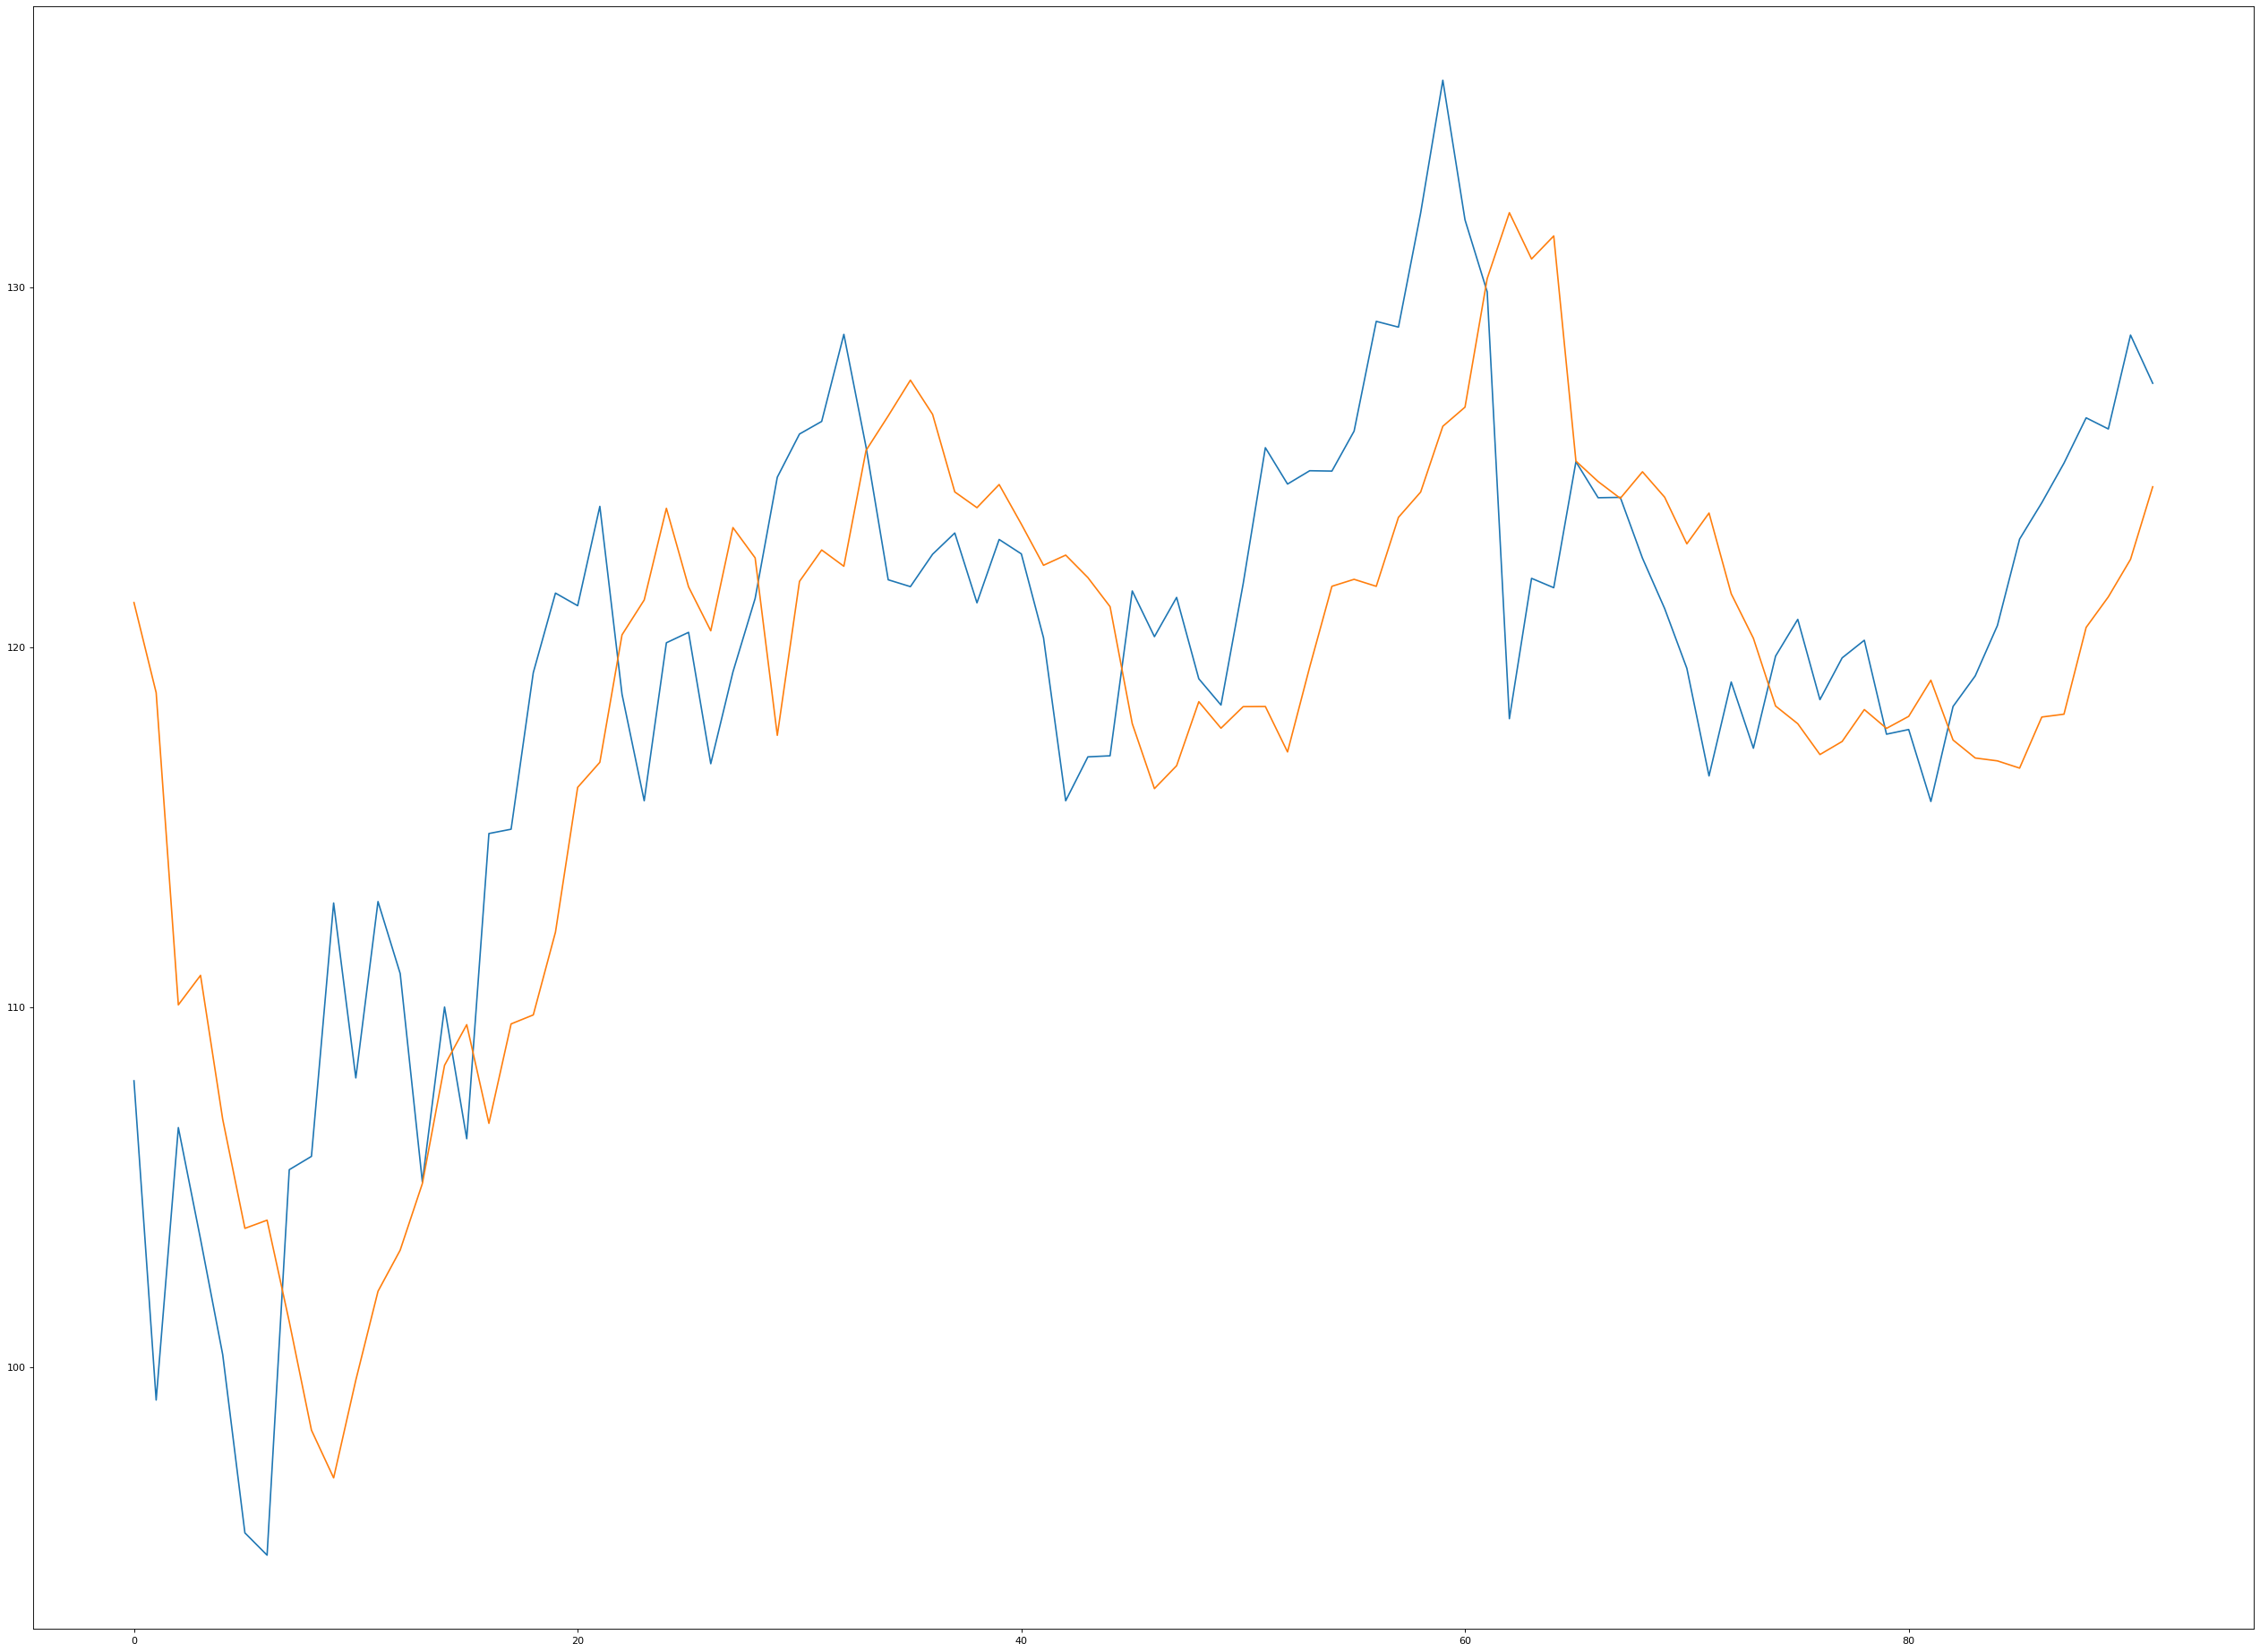

In [35]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(92), true_y_test[-92:])
plt.plot(range(92), predicted_y_test[-92:])
plt.show()

##### Last 12 days + prediction of last 6 days

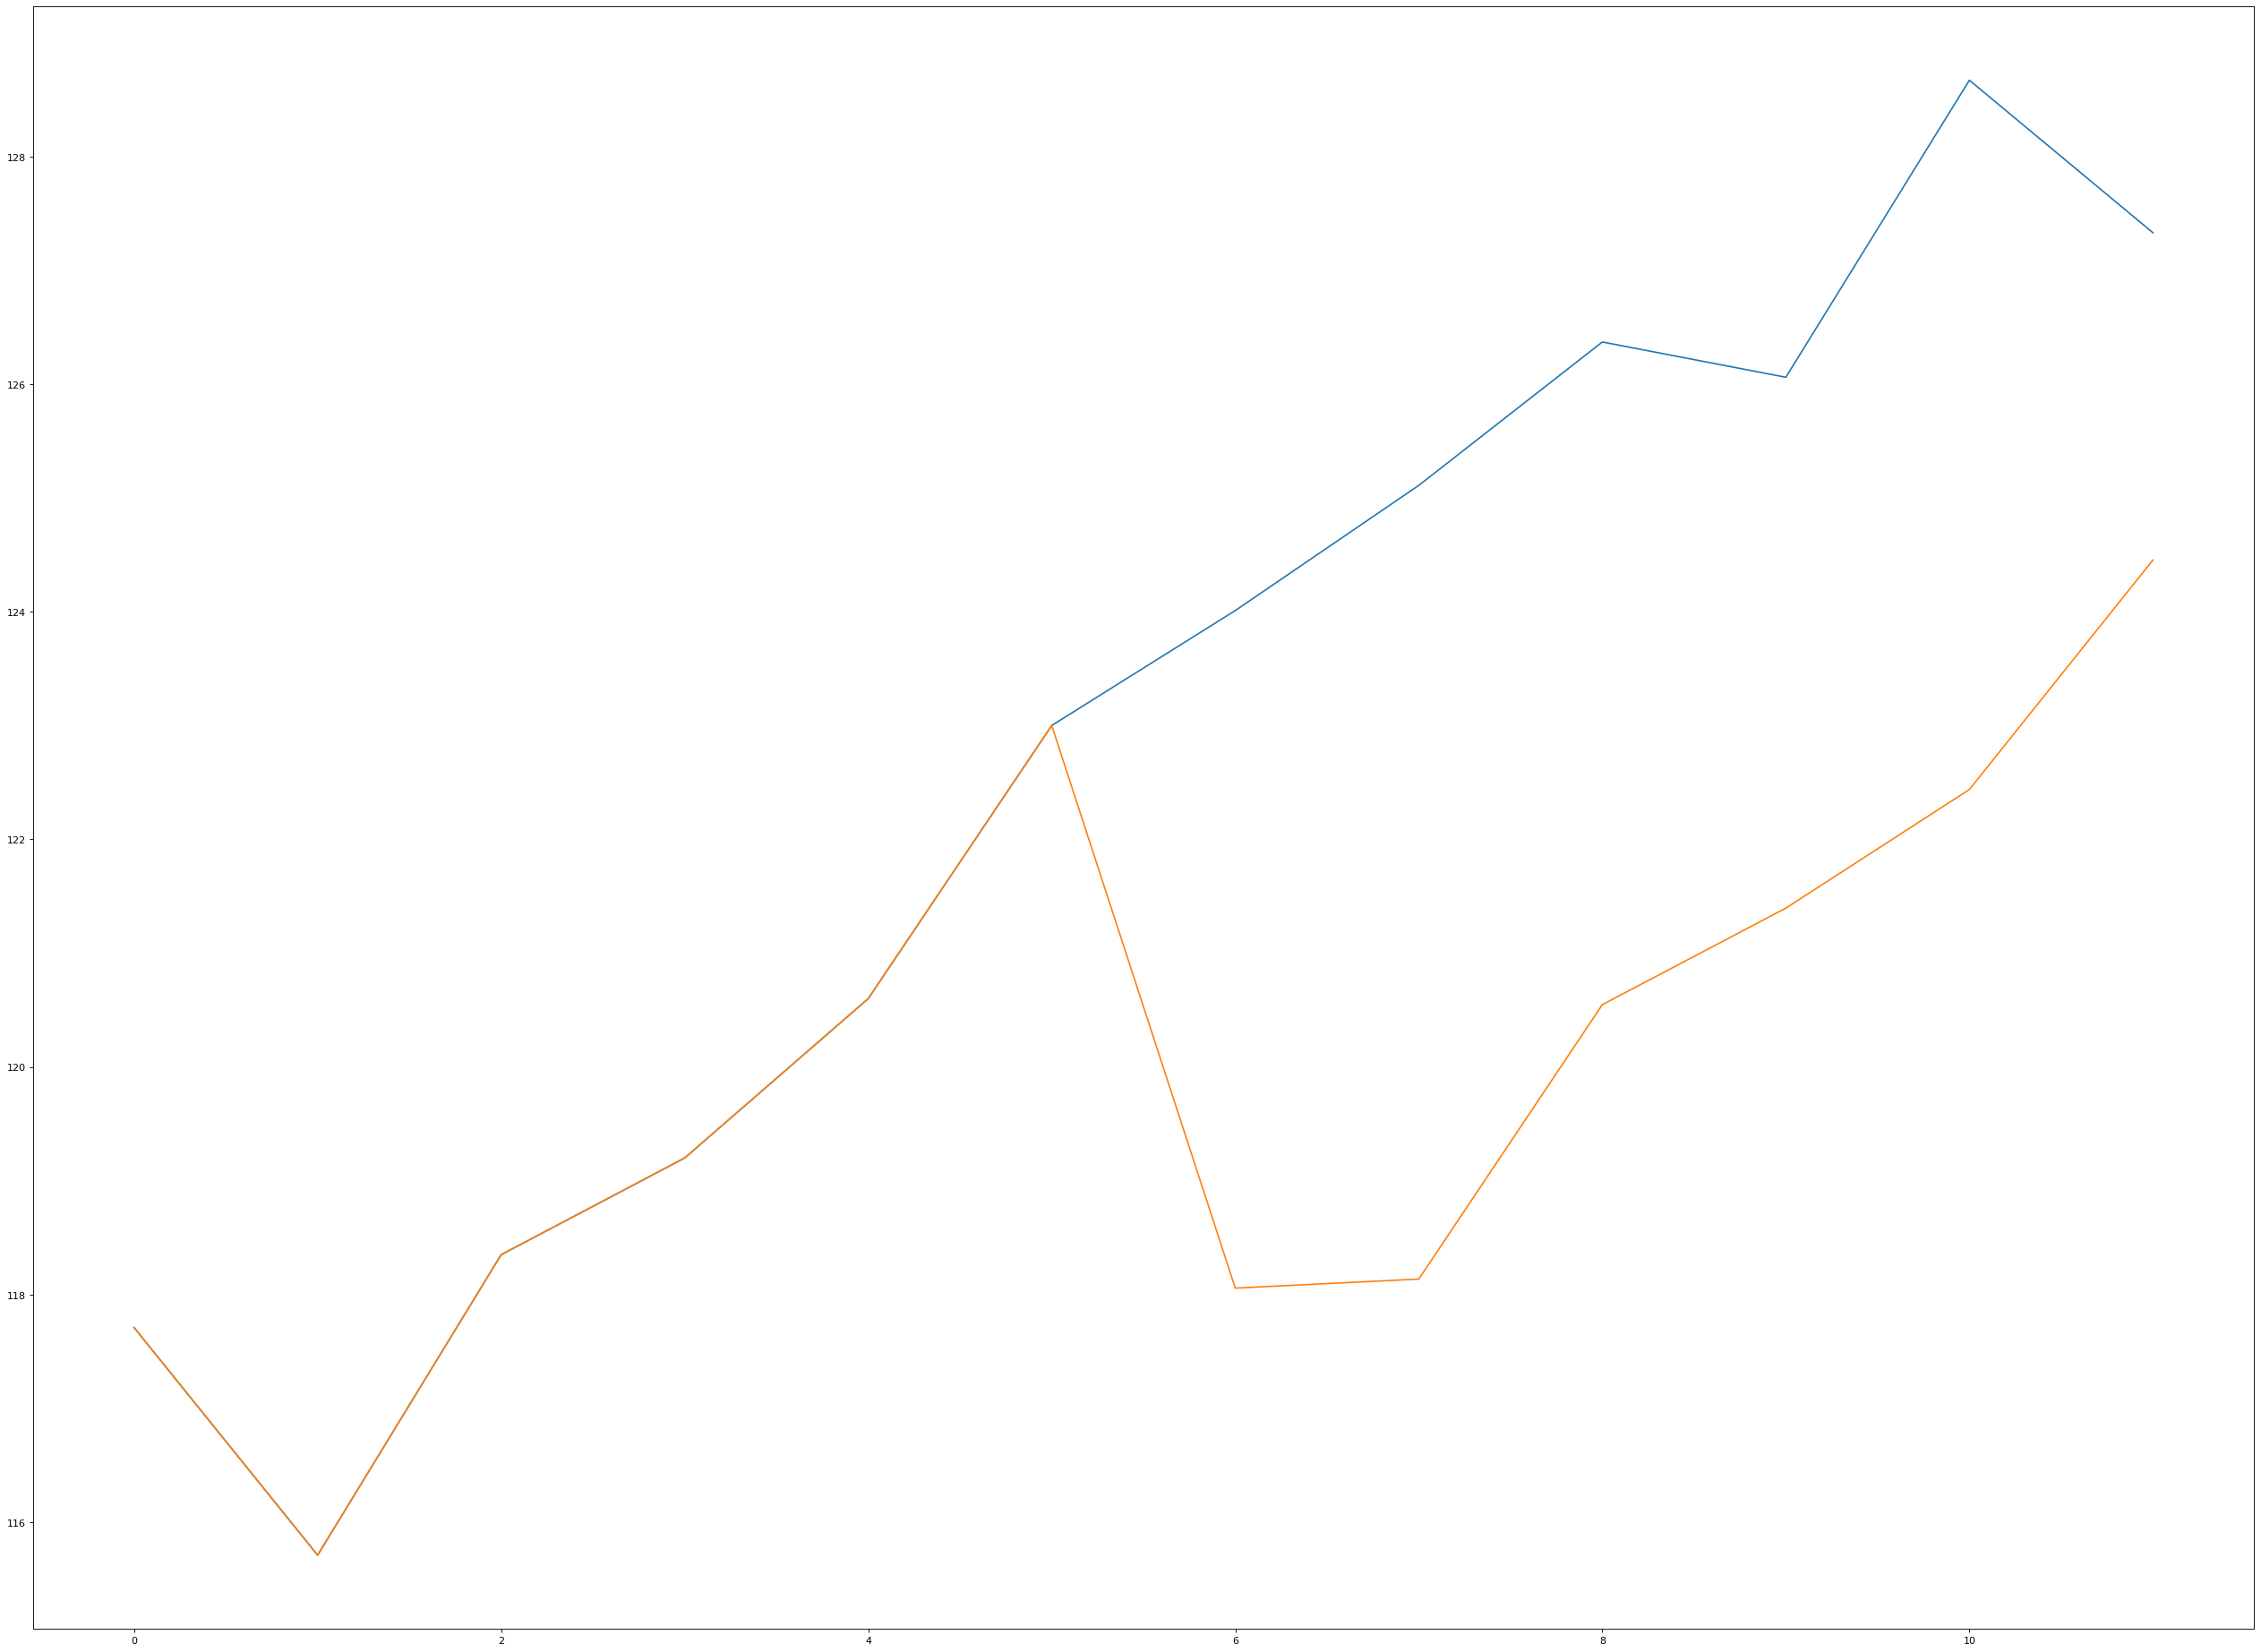

In [36]:
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(12), true_y_test[-12:])
plt.plot(range(12), np.append(true_y_test[-12:-6], predicted_y_test[-6:]))
plt.show()